In [77]:
#IMPORT SOME BASIC LIBRARIES 
import requests
import json
import torch
import os
from tqdm import tqdm

from pathlib import Path
from torch.utils.data import DataLoader
import time

In [78]:
#Data load
with open(r"/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/random_testing/method/meth_full_1351.json", "r") as read_file:
    full = json.load(read_file)

In [79]:
print("length of data :", len(full))

length of data : 1351


In [4]:
#Split the data into three categories
from sklearn.model_selection import train_test_split

train, _ = train_test_split(full, test_size=0.30, random_state=42)
valid, test = train_test_split(_, test_size=0.50, random_state=42)

In [5]:
len(train), len(valid), len(test)

(107, 23, 23)

In [6]:
#Read the dataa and foramting the data 
def read_data(squad):
    contexts = []
    questions = []
    answers = []

    for group in squad:
        context = group['context']
        for qa in group['qas']:
            question = qa['question']
            for answer in qa['answers']:
                contexts.append(context)
                questions.append(question)
                answers.append(answer)

    return contexts, questions, answers

#Call the functions
train_contexts, train_questions, train_answers = read_data(train)
valid_contexts, valid_questions, valid_answers = read_data(valid)
test_contexts, test_questions, test_answers = read_data(test)

In [7]:
len(train_contexts), len(train_answers)

print("shape of train:>>", len(train_contexts))
print("shape of valid:>>", len(valid_contexts))
print("shape of test:>>", len(test_contexts))

shape of train:>> 480
shape of valid:>> 89
shape of test:>> 90


In [8]:
train_contexts[1], train_questions[1], train_answers[1]

('In this study, a mixture of waste plastics and papers were pyrolyzed under mild conditions in batch and tubular reactors. The decomposition reactions were enhanced by the use of synthetic zeolite-based catalysts to obtain a higher yield of volatiles and modifying the product composition. Especially the decomposition reactions and the product properties obtained from the different reactors were compared. Gases were analysed by GC-FID and GC-TCD. This fraction contains hydrogen, carbon-monoxide, carbon-dioxide and hydrocarbons. The pyrolysis oils have oxygen-containing compounds, such as alcohols, aldehyde, ketones, carboxylic acids or phenol and its derivative. Not only the reactor configurations but also the catalysts had an effect to the product properties, because the catalysts with alkali characters showed advanced behaviour in the reduction of oxygenated hydrocarbons, while high synthetic zeolite catalysts can increase the saturation and isomerization reactions. The long-term beh

In [9]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two so we fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters
        else:
            answer['answer_end'] = end_idx

add_end_idx(train_answers, train_contexts)
add_end_idx(valid_answers, valid_contexts)
add_end_idx(test_answers, test_contexts)

In [10]:
# You can see that now we get the answer_end also
print(train_questions[-10])
print(train_answers[-10])
print(train_contexts[-10])

What are the methods used?
{'text': 'conversion', 'answer_start': 183, 'answer_end': 193}
Recovering waste plastics by catalytic fast pyrolysis to selectively generate aromatic hydrocarbons is a promising approach to dispose of solid wastes. In the present work, catalytic conversion of polystyrene over ultra-stable Y zeolites (USY) was conducted to directionally produce benzene and ethylbenzene. Experimental results indicated that catalyst type considerably affected the distribution of aromatic hydrocarbons, and USY with high surface area (734 m2/g), large pore size (5.6 nm), and an abundant amount of strong acid sites (1.21 mmol/g) exhibited the most effective shape selectivity for ethylbenzene and benzene generation as the yield enhanced rate reached 401.8% and 61.1%, respectively. Plastic type also played a vital role in the formation of desirable aromatic hydrocarbons, and polystyrene was more beneficial to the production of ethylbenzene as a 54-fold increase was obtained compared 

In [11]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
valid_encodings = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)
test_encodings = tokenizer(test_contexts, test_questions, truncation=True, padding=True)

In [12]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [13]:
no_of_encodings = len(valid_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 89 context-question pairs


In [14]:
no_of_encodings = len(test_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 90 context-question pairs


In [15]:
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 480 context-question pairs


In [16]:
print(train_encodings['input_ids'][0])

[101, 1130, 1142, 2025, 117, 170, 7759, 1104, 5671, 5828, 1116, 1105, 4580, 1127, 185, 12577, 23415, 5305, 1223, 10496, 2975, 1107, 15817, 1105, 15511, 5552, 25521, 119, 1109, 25898, 9535, 1127, 9927, 1118, 1103, 1329, 1104, 13922, 195, 8209, 21998, 118, 1359, 20546, 1116, 1106, 6268, 170, 2299, 10972, 1104, 23332, 1116, 1105, 22015, 1158, 1103, 3317, 5239, 119, 11008, 1103, 25898, 9535, 1105, 1103, 3317, 4625, 3836, 1121, 1103, 1472, 25521, 1127, 3402, 119, 12384, 1279, 1127, 24443, 6834, 1174, 1118, 144, 1658, 118, 143, 9949, 1105, 144, 1658, 118, 157, 14107, 119, 1188, 13394, 2515, 9986, 117, 6302, 118, 19863, 22040, 117, 6302, 118, 15163, 1105, 177, 19694, 8766, 8868, 1116, 119, 1109, 185, 12577, 23415, 4863, 23638, 1138, 7621, 118, 4051, 10071, 117, 1216, 1112, 6272, 1116, 117, 2393, 2007, 7889, 2007, 117, 180, 22273, 1279, 117, 1610, 8757, 7777, 1596, 13087, 1137, 185, 10436, 4063, 1105, 1157, 14478, 119, 1753, 1178, 1103, 15056, 25209, 1133, 1145, 1103, 20546, 1116, 1125, 1126, 

In [17]:
tokenizer.decode(train_encodings['input_ids'][0])

'[CLS] In this study, a mixture of waste plastics and papers were pyrolyzed under mild conditions in batch and tubular reactors. The decomposition reactions were enhanced by the use of synthetic zeolite - based catalysts to obtain a higher yield of volatiles and modifying the product composition. Especially the decomposition reactions and the product properties obtained from the different reactors were compared. Gases were analysed by GC - FID and GC - TCD. This fraction contains hydrogen, carbon - monoxide, carbon - dioxide and hydrocarbons. The pyrolysis oils have oxygen - containing compounds, such as alcohols, aldehyde, ketones, carboxylic acids or phenol and its derivative. Not only the reactor configurations but also the catalysts had an effect to the product properties, because the catalysts with alkali characters showed advanced behaviour in the reduction of oxygenated hydrocarbons, while high synthetic zeolite catalysts can increase the saturation and isomerization reactions. 

In [18]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # print(i)
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # print(i)

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

        encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [19]:
add_token_positions(train_encodings, train_answers)
add_token_positions(valid_encodings, valid_answers)
add_token_positions(test_encodings, test_answers)

In [20]:
train_encodings['start_positions'][:10]

[115, 116, 116, 38, 44, 43, 191, 80, 89, 123]

# Dataset definition 🗄️
We have to define our dataset using the PyTorch Dataset class from torch.utils in order create our dataloaders after that.

In [23]:
class SQuAD_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [24]:
train_dataset = SQuAD_Dataset(train_encodings)
valid_dataset = SQuAD_Dataset(valid_encodings)
test_dataset  = SQuAD_Dataset(test_encodings)

**Dataloader**

In [26]:
from torch.utils.data import DataLoader

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

# Load pretrained bert
We are going to use the bert-case-uncased from the huggingface transformers.

In [27]:
from transformers import BertForQuestionAnswering

# model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

In [28]:
# Check on the available device - use GPU
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

Working on cuda:1


In [30]:
from transformers import AdamW
import torch.nn as nn

model = BertForQuestionAnswering.from_pretrained('bert-base-cased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
epochs = 10
# epochs = 4

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and a

In [31]:
val_loader = valid_loader

In [32]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 100

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()

    loss_of_epoch = 0

    print("############Train############")

    for batch_idx,batch in enumerate(train_loader): 

        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        # do a backwards pass 
        loss.backward()
        # update the weights
        optim.step()
        # Find the total loss
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    ##########Evaluation##################

    # Set model in evaluation mode
    model.eval()

    print("############Evaluate############")

    loss_of_epoch = 0

    for batch_idx,batch in enumerate(val_loader):

        with torch.no_grad():

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            # Find the total loss
            loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    # Print each epoch's time and train/val loss 
    print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 100 / 1219 
Loss: 2.0 

Batch 200 / 1219 
Loss: 1.6 

Batch 300 / 1219 
Loss: 1.4 

Batch 400 / 1219 
Loss: 1.5 

Batch 500 / 1219 
Loss: 1.8 

Batch 600 / 1219 
Loss: 1.9 

Batch 700 / 1219 
Loss: 1.5 

Batch 800 / 1219 
Loss: 1.1 

Batch 900 / 1219 
Loss: 1.4 

Batch 1000 / 1219 
Loss: 1.4 

Batch 1100 / 1219 
Loss: 1.3 

Batch 1200 / 1219 
Loss: 1.5 

############Evaluate############
Batch 100 / 255 
Loss: 1.7 

Batch 200 / 255 
Loss: 2.3 


-------Epoch  1 -------
Training Loss: 1.6784422242123147 
Validation Loss: 1.453340663395676 
Time:  973.7217879295349 
----------------------- 


############Train############
Batch 100 / 1219 
Loss: 1.3 

Batch 200 / 1219 
Loss: 1.6 

Batch 300 / 1219 
Loss: 1.4 

Batch 400 / 1219 
Loss: 1.6 

Batch 500 / 1219 
Loss: 1.4 

Batch 600 / 1219 
Loss: 1.6 

Batch 700 / 1219 
Loss: 1.6 

Batch 800 / 1219 
Loss: 1.9 

Batch 900 / 1219 
Loss: 1.5 

Batch 1000 / 1219 
Loss: 1.6 

Batch 1100 / 1219 
Loss: 1.4 

Batch

**Save the model in my drive in order not to run it each time**

In [33]:
model_path = "/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/methods/pretrain_model/meth_only/"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/methods/pretrain_model/meth_only/tokenizer_config.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/methods/pretrain_model/meth_only/special_tokens_map.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/methods/pretrain_model/meth_only/vocab.txt',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/methods/pretrain_model/meth_only/added_tokens.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/methods/pretrain_model/meth_only/tokenizer.json')

# Step 12: Plot train and validation losses

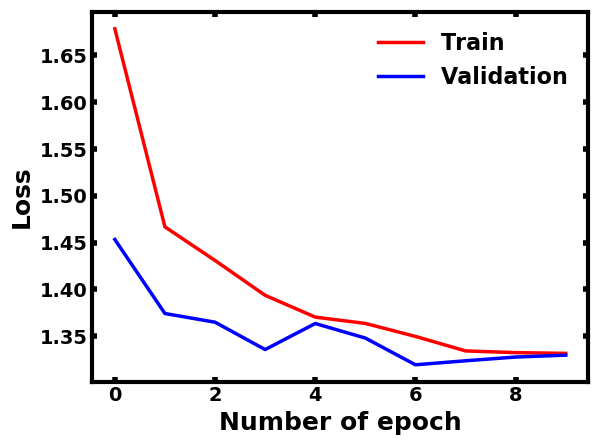

In [35]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, color='red', label= 'Train', linewidth=2.5)
plt.plot(range(len(val_losses)), val_losses, color =  'Blue', label = 'Validation', linewidth=2.5)
#plt.title('Classification loss')
plt.legend(frameon=False,prop={'weight':'bold',"size":16})
plt.xlabel('Number of epoch',fontweight='bold', fontsize=18)
plt.ylabel('Loss',fontweight='bold', fontsize=18)
#plt.title('GP Regression',fontweight='bold')
#plt.axis('square')
from matplotlib import rc

plt.rcParams['axes.linewidth'] = 3

plt.tick_params(axis="x", direction="in",width=4)
plt.tick_params(axis="y", direction="in", width=4)

rc('font', weight='bold')

plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.xticks(rotation = '0', fontsize = 14)
plt.yticks(rotation = '0', fontsize = 14)
#plt.legend(handles=h, labels=np.arange(0.9,0.85), title="Quality")
#plt.rcParams.update({'legend.fontweight':'bold'}
#plt.savefig('line_plot.pdf')
plt.savefig(r'/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/methods/curve_learnin/learning_react.pdf', dpi=5000)
plt.show()#

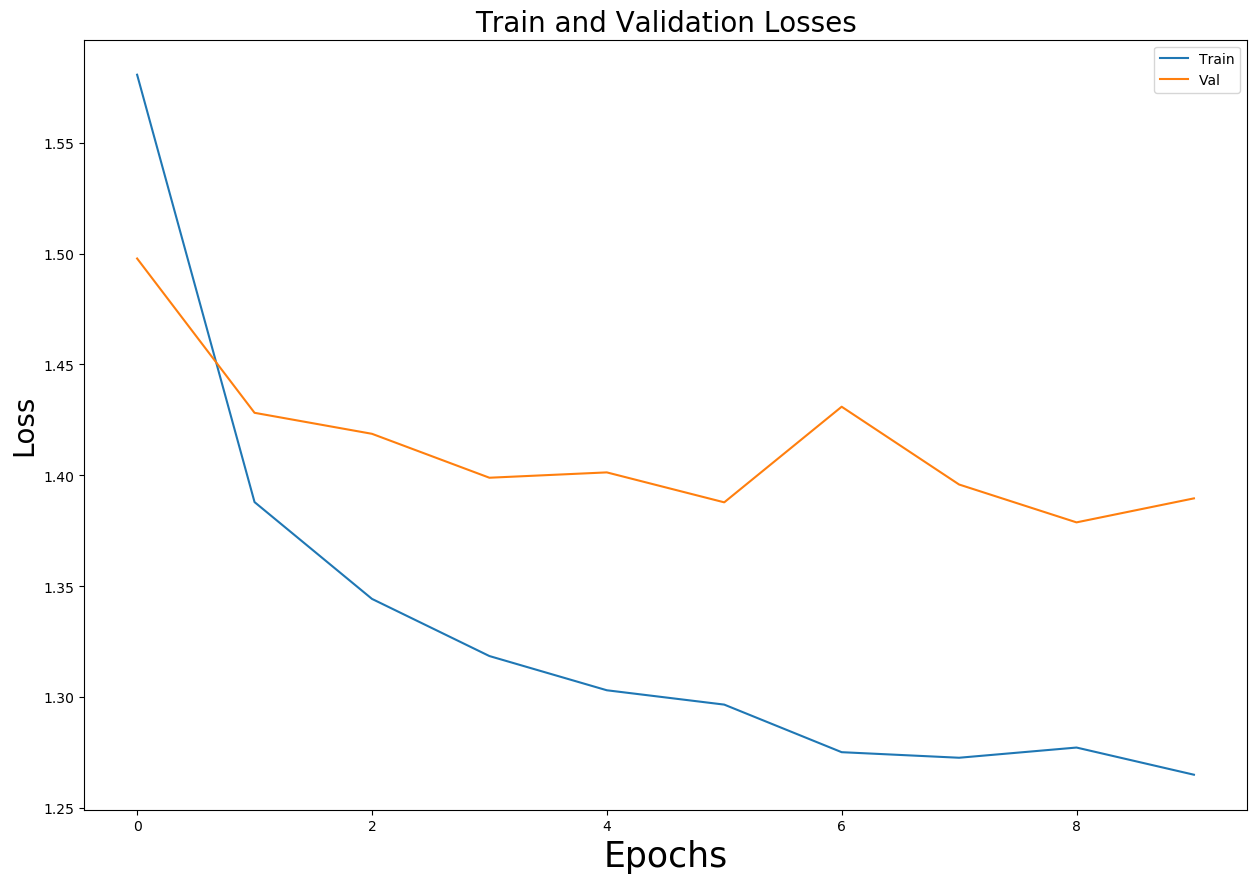

In [29]:

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

# Test
We are evaluating the model on the validation set by checking the model's predictions for the answer's start and end indexes and comparing with the true ones.

In [63]:
model.eval()

acc = []

for batch in tqdm(valid_loader):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)
        
        
        
        acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
        
        

acc = sum(acc)/len(acc)

print("\n\nT/P\tanswer_start\tanswer_end\n")
for i in range(len(start_true)):
    print(f"true\t{start_true[i]}\t{end_true[i]}\n"
        f"pred\t{start_pred[i]}\t{end_pred[i]}\n")

100%|████████████████████████████████████████████████████████████████| 267/267 [01:08<00:00,  3.90it/s]



T/P	answer_start	answer_end

true	211	211
pred	211	353

true	210	212
pred	211	353

true	350	353
pred	211	353

true	349	353
pred	211	353

true	179	181
pred	178	181

true	175	183
pred	178	181

true	275	280
pred	178	181

true	178	181
pred	178	181

true	385	390
pred	178	181

true	182	188
pred	185	188

true	185	188
pred	185	188

true	203	207
pred	185	188

true	301	305
pred	185	188



In [64]:
acc

0.40977023921432565

# Data load for testing

**Respectively, load the saved model**

In [80]:
from transformers import BertForQuestionAnswering, BertTokenizerFast

#Load the pretrained weights
model_path ="/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/methods/pretrain_model/meth_only/"
model = BertForQuestionAnswering.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

#Specify the cuda
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

model = model.to(device)

Working on cuda:1


In [81]:
##data list
context = []
answerss = []
question =[]

#loop data points
def extractquestions(test):
    for trai in test:
        context.append(trai['context'])
        question.append(trai['qas'][0]['question'])

    for sample in test:
        gold_answers = []
        for ans in sample['qas'][0]['answers']:
            gold_answers.append(ans['text'])
        answerss.append(gold_answers)
        
    return context, answerss, question

#Data for testing
context, answerss, question = extractquestions(full)

In [82]:
#Define the metric lists
F1 = []
preci = []
recal = []

In [83]:
def get_prediction_f1_0(context, question, f):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)
        start_logits = outputs[0]
        end_logits = outputs[1]

        def to_list(tensor):
            return tensor.detach().cpu().tolist()

        # convert our start and end logit tensors to lists
        start_logits = to_list(start_logits)[0]
        end_logits = to_list(end_logits)[0]

        # sort our start and end logits from largest to smallest, keeping track of the index
        start_idx_and_logit = sorted(enumerate(start_logits), key=lambda x: x[1], reverse=True)
        end_idx_and_logit = sorted(enumerate(end_logits), key=lambda x: x[1], reverse=True)

        start_indexes = [idx for idx, logit in start_idx_and_logit[:5]]
        end_indexes = [idx for idx, logit in end_idx_and_logit[:5]]

        # convert the token ids from a tensor to a list
        tokens = to_list(inputs['input_ids'])[0]

        # question tokens are defined as those between the CLS token (101, at position 0) and first SEP (102) token 
        question_indexes = [i+1 for i, token in enumerate(tokens[1:tokens.index(102)])]

        import collections

        # keep track of all preliminary predictions
        PrelimPrediction = collections.namedtuple( 
            "PrelimPrediction", ["start_index", "end_index", "start_logit", "end_logit"]
        )

        prelim_preds = []
        for start_index in start_indexes:
            for end_index in end_indexes:
                # throw out invalid predictions
                if start_index in question_indexes:
                    continue
                if end_index in question_indexes:
                    continue
                if end_index < start_index:
                    continue
                prelim_preds.append(
                    PrelimPrediction(
                        start_index = start_index,
                        end_index = end_index,
                        start_logit = start_logits[start_index],
                        end_logit = end_logits[end_index]
                    )
                )

        # sort preliminary predictions by their score
        prelim_preds = sorted(prelim_preds, key=lambda x: (x.start_logit + x.end_logit), reverse=True)

        # keep track of all best predictions
        BestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
            "BestPrediction", ["text", "start_logit", "end_logit"]
        )

        nbest = []
        nbest_text =[]
        seen_predictions = []
        print("best answers: ",f)
        for pred in prelim_preds:

            # for now we only care about the top 5 best predictions
            if len(nbest) >= f: 
                break

            # loop through predictions according to their start index
            if pred.start_index > 0: # non-null answers have start_index > 0

                text = tokenizer.convert_tokens_to_string(
                    tokenizer.convert_ids_to_tokens(
                        tokens[pred.start_index:pred.end_index+1]
                    )
                )
                # clean whitespace
                text = text.strip()
                text = " ".join(text.split())

                if text in seen_predictions:
                    continue

                # flag this text as being seen -- if we see it again, don't add it to the nbest list
                seen_predictions.append(text) 

                # add this text prediction to a pruned list of the top 5 best predictions
                nbest.append(BestPrediction(text=text, start_logit=pred.start_logit, end_logit=pred.end_logit))

        # and don't forget -- include the null answer!
        nbest.append(BestPrediction(text="", start_logit=start_logits[0], end_logit=end_logits[0]))

    except:
        print('no available')
        
        seen_predictions = ["nothings"]

    return seen_predictions

In [84]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [85]:
def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [86]:
def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

In [87]:
def question_answer(context, question,answerss,f):
    prediction = get_prediction_f1_0(context,question,f)
    #em_score = exact_match(prediction, answer)
    #f1_score = compute_f1(prediction, answer)
    temp_f1 = []
    for pre in prediction:
        
        print(answerss, pre)

        if len(answerss) != 0:
            em_score = max((exact_match(pre.replace(" ", ""), answer.replace(" ", ""))) for answer in answerss)
    #         for answer in answerss:
    #             presion, recall = comput_prec_recall(prediction, answer.replace(" ", ""))
    # #         presion, recall = max((comput_prec_recall(prediction, answer)) for answer in answerss)
    #         print(presion, recall)

            f1_score = max((compute_f1(pre.replace(" ", ""), answer.replace(" ", ""))) for answer in answerss)
            print(f1_score)
    #         if f1_score == 1.0:
            temp_f1.append(f1_score)
    

    #         elif f1_score == 0:
    #             prediction_0 = get_prediction_f1_0(context,question)
    #             print(prediction_0)

    #             f1_score_0 = max((compute_f1(prediction_0, answer)) for answer in answerss)
    #             print(f1_score_0)
    #             F1.append(f1_score_0)

    #         preci.append(presion)
    #         recal.append(recall)
        else:
            em_score = 0
            f1_score = 0
            temp_f1 = [0]
            
    #if max(temp_f1) <=1.0:
        
    if max(temp_f1) ==1.0:
        F1.append(max(temp_f1))
        
    else:
        temp_f1 = []
        for pre in prediction:

            print(answerss, pre)

            if len(answerss) != 0:
                em_score = max((exact_match(pre, answer)) for answer in answerss)
        #         for answer in answerss:
        #             presion, recall = comput_prec_recall(prediction, answer.replace(" ", ""))
        # #         presion, recall = max((comput_prec_recall(prediction, answer)) for answer in answerss)
        #         print(presion, recall)

                f1_score = max((compute_f1(pre, answer)) for answer in answerss)
                print(f1_score)
        #         if f1_score == 1.0:
                temp_f1.append(f1_score)


        #         elif f1_score == 0:
        #             prediction_0 = get_prediction_f1_0(context,question)
        #             print(prediction_0)

        #             f1_score_0 = max((compute_f1(prediction_0, answer)) for answer in answerss)
        #             print(f1_score_0)
        #             F1.append(f1_score_0)

        #         preci.append(presion)
        #         recal.append(recall)
            else:
                em_score = 0
                f1_score = 0
                temp_f1 = [0]
                
        F1.append(max(temp_f1))

    
    
    
    print(f'Question: {question}')
    print(f'Prediction: {prediction}')
    print(f'True Answer: {answerss}')
    print(f'Exact match: {em_score}')
    print(f'F1 score: {max(temp_f1)}\n')

In [88]:
for i in range(len(full)):
    print(i)
    question_answer(context[i], question[0],answerss[i], len(answerss[i]))

0
best answers:  2
['pyrolysis', 'pyrolysis oil'] pyrolysis oil
1.0
['pyrolysis', 'pyrolysis oil'] pyrolysis
1.0
Question: What are the methods used?
Prediction: ['pyrolysis oil', 'pyrolysis']
True Answer: ['pyrolysis', 'pyrolysis oil']
Exact match: True
F1 score: 1.0

1
best answers:  2
['thermal', 'infrared thermal analyses'] thermal
1.0
['thermal', 'infrared thermal analyses'] thermally characterized for the assessment of recycled material quality. The dirty non - recyclable mixed plastic from municipal solid waste was composed of polypropylene ( 28. 89 % ), polyethylene terephthalate ( 22. 02 % ), polystyrene ( 9. 65 % ) and rigid polyethylene ( 4. 68 % ). Regarding the moisture and dirt content of the mixed plastic fraction, the results were highly variable, mainly due to the heterogeneity of the material, its origin, atmospheric conditions, etc. The average sum of both parameters ( moisture and dirt ) was around 15 %. The mechanical properties were within the expected range for e

best answers:  2
['pyrolysis', 'distilled pyrolysis oil fractions'] pyrolysis
1.0
['pyrolysis', 'distilled pyrolysis oil fractions'] pyrolysis combined with steam cracking being the favored recycling option for the time being. However, today, the high variety and contamination of real waste remains the biggest challenge. This is especially relevant for waste fractions which are difficult or even impossible to recycle mechanically such as highly mixed municipal plastic waste or marine litter. In this work, we studied the detailed composition and the steam cracking performance of distilled pyrolysis oil fractions
0
Question: What are the methods used?
Prediction: ['pyrolysis', 'pyrolysis combined with steam cracking being the favored recycling option for the time being. However, today, the high variety and contamination of real waste remains the biggest challenge. This is especially relevant for waste fractions which are difficult or even impossible to recycle mechanically such as highly

best answers:  3
['pyrolysis', 'conversion', 'carbon conversion efficiency'] conversion
1.0
['pyrolysis', 'conversion', 'carbon conversion efficiency'] pyrolysis
1.0
['pyrolysis', 'conversion', 'carbon conversion efficiency'] pyrolysis, which can convert it back into chemical feedstock that can then be used to manufacture virgin - quality polymers. However, given that this is an emerging technology not yet used widely in practice, it is not clear if pyrolysis of waste plastics is sustainable on a life cycle basis and how it compares to other plastics waste management options as well as to the production of virgin plastics. Therefore, this study uses life cycle assessment ( LCA ) to compare the environmental impacts of chemical recycling of mixed plastic waste ( MPW ) via pyrolysis with the established waste management alternatives : mechanical recycling and energy recovery. Three LCA studies have been carried out under three perspectives : waste, product and a combination of the two. T

best answers:  2
['thermal', 'hydrothermal liquefaction'] hydrothermal
0
['thermal', 'hydrothermal liquefaction'] ##thermal
1.0
Question: What are the methods used?
Prediction: ['hydrothermal', '##thermal']
True Answer: ['thermal', 'hydrothermal liquefaction']
Exact match: True
F1 score: 1.0

39
best answers:  8
['pyrolysis', 'industrial scale plastic pyrolysis', 'conversion', 'fuel conversion', 'pyrolysis-related articles', 'plastic pyrolysis research', 'plastic pyrolysis', 'plastic pyrolysis progress'] pyrolysis. Indeed, plastic to fuel conversion
0
['pyrolysis', 'industrial scale plastic pyrolysis', 'conversion', 'fuel conversion', 'pyrolysis-related articles', 'plastic pyrolysis research', 'plastic pyrolysis', 'plastic pyrolysis progress'] fuel conversion
1.0
['pyrolysis', 'industrial scale plastic pyrolysis', 'conversion', 'fuel conversion', 'pyrolysis-related articles', 'plastic pyrolysis research', 'plastic pyrolysis', 'plastic pyrolysis progress'] pyrolysis. Indeed, plastic to 

Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors


best answers:  3
['pyrolysis', 'degradation', 'photocatalytic degradation'] pyrolysis, plasma gasification, photocatalytic degradation
0
['pyrolysis', 'degradation', 'photocatalytic degradation'] photocatalytic degradation
1.0
['pyrolysis', 'degradation', 'photocatalytic degradation'] degradation
1.0
Question: What are the methods used?
Prediction: ['pyrolysis, plasma gasification, photocatalytic degradation', 'photocatalytic degradation', 'degradation']
True Answer: ['pyrolysis', 'degradation', 'photocatalytic degradation']
Exact match: True
F1 score: 1.0

53
best answers:  5
['pyrolysis', 'pyrolysis technologies', 'thermal', 'plastic waste thermal decomposition', 'conversion'] pyrolysis technologies for chemical recycling. Kinetic parameters of individual and mixed plastic waste samples that resemble the main components of plastic waste streams ( polyolefins and polyesters ) were determined in this study using thermogravimetric analysis. Strong dependencies of activation energy on co

best answers:  3
['pyrolysis', 'pyrolysis technique', '70–80 % plastic pyrolysis oil'] pyrolysis technique plays an important role which is more ecologically friendly, effective and produces minimal pollutants. It has been observed that using COVID medical waste management ( CMWM ) technology, 70 – 80 % plastic pyrolysis oil
0
['pyrolysis', 'pyrolysis technique', '70–80 % plastic pyrolysis oil'] pyrolysis
1.0
['pyrolysis', 'pyrolysis technique', '70–80 % plastic pyrolysis oil'] pyrolysis technique
1.0
Question: What are the methods used?
Prediction: ['pyrolysis technique plays an important role which is more ecologically friendly, effective and produces minimal pollutants. It has been observed that using COVID medical waste management ( CMWM ) technology, 70 – 80 % plastic pyrolysis oil', 'pyrolysis', 'pyrolysis technique']
True Answer: ['pyrolysis', 'pyrolysis technique', '70–80 % plastic pyrolysis oil']
Exact match: True
F1 score: 1.0

68
best answers:  4
['degradation', 'degradation

best answers:  3
['pyrolysis', 'plastic pyrolysis', 'catalytic pyrolysis'] plastic pyrolysis
1.0
['pyrolysis', 'plastic pyrolysis', 'catalytic pyrolysis'] pyrolysis
1.0
['pyrolysis', 'plastic pyrolysis', 'catalytic pyrolysis'] plastic pyrolysis is particularly promising due to its commercial maturity and complementarity to mechanical recycling. In this paper, recent studies of plastic pyrolysis
0
Question: What are the methods used?
Prediction: ['plastic pyrolysis', 'pyrolysis', 'plastic pyrolysis is particularly promising due to its commercial maturity and complementarity to mechanical recycling. In this paper, recent studies of plastic pyrolysis']
True Answer: ['pyrolysis', 'plastic pyrolysis', 'catalytic pyrolysis']
Exact match: False
F1 score: 1.0

83
best answers:  3
['pyrolysis', 'pyrolysis technique', '70–80 % plastic pyrolysis oil'] pyrolysis technique plays an important role which is more ecologically friendly, effective and produces minimal pollutants. It has been observed th

best answers:  6
['pyrolysis', 'pyrolysis technique', 'pyrolysis', 'The pyrolysis', 'pyrolysis', 'pyrolysis conditions'] pyrolysis technique for the recovery of plastic waste. In that frame, the influence of temperature ( 550°C or 600°C ) on the pyrolysis of pure polypropylene ( PP ), polyethylene ( PE ), polystyrene ( PS ) and polyethylene terephthalate ( PET ) was first studied. It is shown that whatever the type of polymer, aromatic compounds are mainly formed and could reach 55wt. - % of the oil fraction for PP and 31wt. - % for PE at 550°C. In a second step, a PP / PE mixture and a model mixture representative of the packaging plastic waste stream were pyrolyzed to investigate the influence of a combination of polymers on the proportions and composition of the different fractions. The pyrolysis
0
['pyrolysis', 'pyrolysis technique', 'pyrolysis', 'The pyrolysis', 'pyrolysis', 'pyrolysis conditions'] pyrolysis
1.0
['pyrolysis', 'pyrolysis technique', 'pyrolysis', 'The pyrolysis', 'p

best answers:  2
['thermal', 'thermal recycling'] thermal recycling
1.0
['thermal', 'thermal recycling'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal recycling', 'thermal']
True Answer: ['thermal', 'thermal recycling']
Exact match: True
F1 score: 1.0

112
best answers:  2
['conversion', 'bioenergy conversion technologies'] conversion
1.0
['conversion', 'bioenergy conversion technologies'] bioenergy conversion
0
Question: What are the methods used?
Prediction: ['conversion', 'bioenergy conversion']
True Answer: ['conversion', 'bioenergy conversion technologies']
Exact match: False
F1 score: 1.0

113
best answers:  1
['conversion'] conversion
1.0
Question: What are the methods used?
Prediction: ['conversion']
True Answer: ['conversion']
Exact match: True
F1 score: 1.0

114
best answers:  2
['pyrolysis', 'plastic pyrolysis technology'] pyrolysis
1.0
['pyrolysis', 'plastic pyrolysis technology'] plastic pyrolysis
0
Question: What are the methods used?
Prediction: 

best answers:  5
['degradation', 'degradation', 'different degradation behaviors', 'The degradation phenomena', 'degradation status'] degradation
1.0
['degradation', 'degradation', 'different degradation behaviors', 'The degradation phenomena', 'degradation status'] degradation of plastic packaging waste in seawater and under simulated solar radiation by different spectroscopic techniques in view of their potential recycling. Selected packaging products made of polypropylene ( PP ), high - density polyethylene ( HDPE ) and polystyrene ( PS ) were weathered in a Solar Box for 4 cycles of 504 h each ( 21 days ), for a total of 2016 h ( 84 days ). At each aging cycle, digital images of the polymer samples were acquired to investigate surface changes in terms of cracking and fragmentation. Furthermore, color measurements were carried out by reflectance spectrophotometry in the visible range ( VIS : 400 – 700 nm ). Finally, hyperspectral imaging ( HSI ) in the shortwave infrared region ( SW

best answers:  3
['thermal', 'lower thermal conductivity', 'thermal comfort'] thermal properties ( density & thermal conductivity
0
['thermal', 'lower thermal conductivity', 'thermal comfort'] thermal properties
0
['thermal', 'lower thermal conductivity', 'thermal comfort'] thermal properties ( density & thermal
0
['thermal', 'lower thermal conductivity', 'thermal comfort'] thermal properties ( density & thermal conductivity
0.5
['thermal', 'lower thermal conductivity', 'thermal comfort'] thermal properties
0.6666666666666666
['thermal', 'lower thermal conductivity', 'thermal comfort'] thermal properties ( density & thermal
0.4
Question: What are the methods used?
Prediction: ['thermal properties ( density & thermal conductivity', 'thermal properties', 'thermal properties ( density & thermal']
True Answer: ['thermal', 'lower thermal conductivity', 'thermal comfort']
Exact match: False
F1 score: 0.6666666666666666

143
best answers:  5
['thermal', 'thermal response', 'apparent thermal r

best answers:  2
['plastic waste degradation', 'degradation'] degradation
1.0
['plastic waste degradation', 'degradation'] plastic waste degradation
1.0
Question: What are the methods used?
Prediction: ['degradation', 'plastic waste degradation']
True Answer: ['plastic waste degradation', 'degradation']
Exact match: True
F1 score: 1.0

159
best answers:  2
['Biocatalytic depolymerization', 'depolymerization'] Biocatalytic depolymerization
1.0
['Biocatalytic depolymerization', 'depolymerization'] depolymerization
1.0
Question: What are the methods used?
Prediction: ['Biocatalytic depolymerization', 'depolymerization']
True Answer: ['Biocatalytic depolymerization', 'depolymerization']
Exact match: True
F1 score: 1.0

160
best answers:  2
['degradation', 'high degradation time'] degradation
1.0
['degradation', 'high degradation time'] high degradation
0
Question: What are the methods used?
Prediction: ['degradation', 'high degradation']
True Answer: ['degradation', 'high degradation time'

best answers:  6
['degradation', 'enzymatic and/or microbial degradation', 'microbial degradation', 'biodegradation', 'conversion', 'microbial conversion'] microbial degradation
1.0
['degradation', 'enzymatic and/or microbial degradation', 'microbial degradation', 'biodegradation', 'conversion', 'microbial conversion'] degradation
1.0
['degradation', 'enzymatic and/or microbial degradation', 'microbial degradation', 'biodegradation', 'conversion', 'microbial conversion'] microbial degradation of plastic wastes and the catabolism of plastic monomers have been intensively studied. In this review, we focus on recent advances and key barriers in the biotechnological upcycling of plastic wastes. We also given an overview of the microbial degradation of plastic wastes. Specifically, recent research on the biodegradation of plastics via PET hydrolase ( PETase ) as a representative plastic - degrading enzyme is discussed. Additionally, this review covers ( i ) the microbial conversion
0
['degr

best answers:  2
['thermal', 'thermal insulation blocks'] thermal insulation blocks
1.0
['thermal', 'thermal insulation blocks'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal insulation blocks', 'thermal']
True Answer: ['thermal', 'thermal insulation blocks']
Exact match: True
F1 score: 1.0

190
best answers:  2
['pyrolysis', 'pyrolysis products'] pyrolysis products
1.0
['pyrolysis', 'pyrolysis products'] pyrolysis, with the aim of removing tetrabromobisphenol A ( TBBPA ) from some polymeric blends, with composition that simulates the plastic part of WEEE. Different extractive conditions ( extractive temperatures, solvent systems and times ) were examined in order to find the optimal combination. Blends were analysed by X - ray fluorescence ( XRF ) before and after the microwave pretreatment, so as to estimate the bromine reduction. Fourier transform infrared spectroscopy ( FTIR ) analysis of the solvent systems used took place in order to explore the possible 

best answers:  2
['pyrolysis', 'waste plastic pyrolysis oil'] pyrolysis
1.0
['pyrolysis', 'waste plastic pyrolysis oil'] waste plastic pyrolysis
0
Question: What are the methods used?
Prediction: ['pyrolysis', 'waste plastic pyrolysis']
True Answer: ['pyrolysis', 'waste plastic pyrolysis oil']
Exact match: False
F1 score: 1.0

206
no available
['pyrolysis', 'pyrolysis', 'laboratory pyrolysis investigation', 'conversion', 'Friedman isoconversional model-free method non-linear multivariate regression method', 'pyrolysis process', 'All pyrolysis products'] nothings
0
['pyrolysis', 'pyrolysis', 'laboratory pyrolysis investigation', 'conversion', 'Friedman isoconversional model-free method non-linear multivariate regression method', 'pyrolysis process', 'All pyrolysis products'] nothings
0
Question: What are the methods used?
Prediction: ['nothings']
True Answer: ['pyrolysis', 'pyrolysis', 'laboratory pyrolysis investigation', 'conversion', 'Friedman isoconversional model-free method non-li

best answers:  3
['pyrolysis', 'thermal', 'thermal treatment'] thermal treatment
1.0
['pyrolysis', 'thermal', 'thermal treatment'] thermal
1.0
['pyrolysis', 'thermal', 'thermal treatment'] pyrolysis are promising alternatives to thermal treatment
0
Question: What are the methods used?
Prediction: ['thermal treatment', 'thermal', 'pyrolysis are promising alternatives to thermal treatment']
True Answer: ['pyrolysis', 'thermal', 'thermal treatment']
Exact match: False
F1 score: 1.0

221
best answers:  1
['pyrolysis'] pyrolysis
1.0
Question: What are the methods used?
Prediction: ['pyrolysis']
True Answer: ['pyrolysis']
Exact match: True
F1 score: 1.0

222
best answers:  2
['conversion', 'conversion efficiency'] conversion
1.0
['conversion', 'conversion efficiency'] conversion efficiency
1.0
Question: What are the methods used?
Prediction: ['conversion', 'conversion efficiency']
True Answer: ['conversion', 'conversion efficiency']
Exact match: True
F1 score: 1.0

223
best answers:  2
['the

best answers:  3
['thermal', 'mechanical thermal properties', 'superior mechanical thermal properties'] thermal
1.0
['thermal', 'mechanical thermal properties', 'superior mechanical thermal properties'] thermal properties, antibacterial properties, and biocompatibility of the CSP / PLA composites were then assessed. Our results revealed that the tensile strength and flexural strength of the ISCSP / PLA composites reached 58. 71 and 90. 11 MPa, which were 28. 6 % and 28. 8 % higher than that of pure PLA, respectively. The glass transition and melting temperatures of the composites remained similar to those of pure PLA. Interestingly, the addition of CSP increased PLA crystallinity, which could be attributed to the nucleation effect of CSP in the system. The antibacterial activity of the PLA - 1. 5ESCSP composite samples against Escherichia coli ( E. coli ) was greater than 99 %. More importantly, the live / dead assay showed that the CSP / PLA composites possessed excellent biocompatibi

best answers:  2
['degradation effect', 'degradation'] degradation effect
1.0
['degradation effect', 'degradation'] degradation
1.0
Question: What are the methods used?
Prediction: ['degradation effect', 'degradation']
True Answer: ['degradation effect', 'degradation']
Exact match: True
F1 score: 1.0

267
best answers:  5
['thermal', 'thermal insulation value', 'degradation', 'soil burial degradation', 'The superior thermal insulation value'] thermal insulation value, and light transmittance, were determined through laboratory tests. Other parameters, including soil moisture content, soil temperature, weed suppression, agronomic traits, cotton yield, and soil burial degradation
0
['thermal', 'thermal insulation value', 'degradation', 'soil burial degradation', 'The superior thermal insulation value'] thermal insulation value, and light transmittance, were determined through laboratory tests. Other parameters, including soil moisture content, soil temperature, weed suppression, agronomi

best answers:  5
['thermal', 'thermal insulation value', 'degradation', 'soil burial degradation', 'The superior thermal insulation value'] thermal insulation value, and light transmittance, were determined through laboratory tests. Other parameters, including soil moisture content, soil temperature, weed suppression, agronomic traits, cotton yield, and soil burial degradation
0
['thermal', 'thermal insulation value', 'degradation', 'soil burial degradation', 'The superior thermal insulation value'] thermal insulation value, and light transmittance, were determined through laboratory tests. Other parameters, including soil moisture content, soil temperature, weed suppression, agronomic traits, cotton yield, and soil burial degradation, were investigated through field tests, with a degradable plastic film as the control. The results showed that the crop yield from the best new mulch treatment ( 2802. 2 kg / arc ) and the degradable plastic film treatment ( 2851. 3 kg / arc ) were simila

best answers:  2
['degradation', 'biodegradation behaviour'] biodegradation
0
['degradation', 'biodegradation behaviour'] ##degradation
1.0
Question: What are the methods used?
Prediction: ['biodegradation', '##degradation']
True Answer: ['degradation', 'biodegradation behaviour']
Exact match: True
F1 score: 1.0

297
best answers:  4
['conversion', 'efficient conversion route', 'thermal', 'catalytic hydrothermal liquefaction (HTL) process'] efficient conversion
0
['conversion', 'efficient conversion route', 'thermal', 'catalytic hydrothermal liquefaction (HTL) process'] conversion
1.0
['conversion', 'efficient conversion route', 'thermal', 'catalytic hydrothermal liquefaction (HTL) process'] efficient conversion route for prosopis juliflora ( PJ ) biomass into high - quality bio - oil through catalytic hydrothermal
0
['conversion', 'efficient conversion route', 'thermal', 'catalytic hydrothermal liquefaction (HTL) process'] catalytic hydrothermal
0
Question: What are the methods used?


best answers:  2
['thermal', 'thermal behaviour'] thermal
1.0
['thermal', 'thermal behaviour'] thermal behaviour
1.0
Question: What are the methods used?
Prediction: ['thermal', 'thermal behaviour']
True Answer: ['thermal', 'thermal behaviour']
Exact match: True
F1 score: 1.0

312
best answers:  4
['degradation', "synthetic plastics' biodegradation", 'entire plastic biodegradation process', 'biodegradation process'] ##degradation
1.0
['degradation', "synthetic plastics' biodegradation", 'entire plastic biodegradation process', 'biodegradation process'] synthetic plastics'biodegradation
1.0
['degradation', "synthetic plastics' biodegradation", 'entire plastic biodegradation process', 'biodegradation process'] biodegradation
0
['degradation', "synthetic plastics' biodegradation", 'entire plastic biodegradation process', 'biodegradation process'] entire plastic biodegradation process
1.0
Question: What are the methods used?
Prediction: ['##degradation', "synthetic plastics'biodegradation"

best answers:  2
['depolymerization', 'chemical depolymerization'] chemical depolymerization
1.0
['depolymerization', 'chemical depolymerization'] depolymerization
1.0
Question: What are the methods used?
Prediction: ['chemical depolymerization', 'depolymerization']
True Answer: ['depolymerization', 'chemical depolymerization']
Exact match: True
F1 score: 1.0

327
best answers:  1
['thermal'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal']
True Answer: ['thermal']
Exact match: True
F1 score: 1.0

328
best answers:  5
['pyrolysis', 'pyrolysis', 'novel, continuous, microwave-assisted pyrolysis (CMAP)', 'Higher pyrolysis temperatures', 'pyrolysis temperature'] pyrolysis of plastic wastes was conducted in a novel, continuous, microwave - assisted pyrolysis ( CMAP ) system for fuel production ; the effects of temperature, plastic composition, and catalysis on the product yields and composition were investigated. Higher pyrolysis temperatures
0
['pyrolysis', 'pyrolys

best answers:  2
['depolymerization', 'chemical depolymerization'] chemical depolymerization
1.0
['depolymerization', 'chemical depolymerization'] depolymerization
1.0
Question: What are the methods used?
Prediction: ['chemical depolymerization', 'depolymerization']
True Answer: ['depolymerization', 'chemical depolymerization']
Exact match: True
F1 score: 1.0

342
best answers:  1
['thermal'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal']
True Answer: ['thermal']
Exact match: True
F1 score: 1.0

343
best answers:  5
['pyrolysis', 'pyrolysis', 'novel, continuous, microwave-assisted pyrolysis (CMAP)', 'Higher pyrolysis temperatures', 'pyrolysis temperature'] pyrolysis of plastic wastes was conducted in a novel, continuous, microwave - assisted pyrolysis ( CMAP ) system for fuel production ; the effects of temperature, plastic composition, and catalysis on the product yields and composition were investigated. Higher pyrolysis temperatures
0
['pyrolysis', 'pyrolys

best answers:  11
['thermal', 'thermal cracking method', 'The pyrolysis process', 'pyrolysis', 'effective pyrolysis temperatures', 'The obtained plastic pyrolysis fuel', 'plastic pyrolysis fuel', 'Plastic pyrolysis fuel', 'The plastic pyrolysis fuel', 'plastic pyrolysis fuel', 'brake thermal efficiency'] thermal cracking method is explored. The pyrolysis process was carried out at a wide range of temperatures in the absence of oxygen. About 78 % ( w / w ) of the liquid yield was extracted between the effective pyrolysis temperatures of 370 °C - 380 °C, resulting in a calorific value of 38. 53 MJ / kg. The obtained plastic pyrolysis fuel
0
['thermal', 'thermal cracking method', 'The pyrolysis process', 'pyrolysis', 'effective pyrolysis temperatures', 'The obtained plastic pyrolysis fuel', 'plastic pyrolysis fuel', 'Plastic pyrolysis fuel', 'The plastic pyrolysis fuel', 'plastic pyrolysis fuel', 'brake thermal efficiency'] thermal cracking method is explored. The pyrolysis process was ca

best answers:  4
['degradation', 'degradation', 'biotic degradation', 'chemical biotic degradation processes'] degradation
1.0
['degradation', 'degradation', 'biotic degradation', 'chemical biotic degradation processes'] degradation of plastic wastes via the physical, chemical and biotic methodologies is looked back. The advanced physical techniques are introduced briefly at firstly. Additionally, evaluate on chemical method for plastic decomposition and review on biotic degradation
0
['degradation', 'degradation', 'biotic degradation', 'chemical biotic degradation processes'] biotic degradation
1.0
['degradation', 'degradation', 'biotic degradation', 'chemical biotic degradation processes'] degradation of plastic wastes via the physical, chemical and biotic methodologies is looked back. The advanced physical techniques are introduced briefly at firstly. Additionally, evaluate on chemical method for plastic decomposition and review on bio
0
Question: What are the methods used?
Predicti

best answers:  4
['depolymerization', 'hydrolytic depolymerization', 'hydrolysis', 'hydrolysis'] hydrolytic depolymerization
1.0
['depolymerization', 'hydrolytic depolymerization', 'hydrolysis', 'hydrolysis'] depolymerization
1.0
['depolymerization', 'hydrolytic depolymerization', 'hydrolysis', 'hydrolysis'] hydrolytic depolymerization : colorless and colored bottles. The experiments were carried out in a batch reactor at temperatures from 250 to 400 °C, with reaction period of 1 – 30 min. During the hydrolysis
0
['depolymerization', 'hydrolytic depolymerization', 'hydrolysis', 'hydrolysis'] depolymerization : colorless and colored bottles. The experiments were carried out in a batch reactor at temperatures from 250 to 400 °C, with reaction period of 1 – 30 min. During the hydrolysis
0
Question: What are the methods used?
Prediction: ['hydrolytic depolymerization', 'depolymerization', 'hydrolytic depolymerization : colorless and colored bottles. The experiments were carried out in a ba

best answers:  1
['degradation'] degradation
1.0
Question: What are the methods used?
Prediction: ['degradation']
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

401
best answers:  2
['pyrolysis', 'one-step catalytic pyrolysis'] one - step catalytic pyrolysis
1.0
['pyrolysis', 'one-step catalytic pyrolysis'] pyrolysis
1.0
Question: What are the methods used?
Prediction: ['one - step catalytic pyrolysis', 'pyrolysis']
True Answer: ['pyrolysis', 'one-step catalytic pyrolysis']
Exact match: True
F1 score: 1.0

402
best answers:  2
['thermal', 'excellent thermal behavior'] thermal
1.0
['thermal', 'excellent thermal behavior'] excellent thermal
0
Question: What are the methods used?
Prediction: ['thermal', 'excellent thermal']
True Answer: ['thermal', 'excellent thermal behavior']
Exact match: False
F1 score: 1.0

403
best answers:  2
['thermal', 'differential thermal analysis'] thermal
1.0
['thermal', 'differential thermal analysis'] thermal analysis
0
Question: What are the 

no available
['pyrolysis', 'plastic waste pyrolysis', 'polyolefin pyrolysis'] nothings
0
['pyrolysis', 'plastic waste pyrolysis', 'polyolefin pyrolysis'] nothings
0
Question: What are the methods used?
Prediction: ['nothings']
True Answer: ['pyrolysis', 'plastic waste pyrolysis', 'polyolefin pyrolysis']
Exact match: False
F1 score: 0

429
best answers:  8
['thermal', 'external thermal insulation composite systems', 'pyrolysis', 'pyrolysis', 'pyrolysis oil', 'conversion', 'subsequent thermochemical conversions', 'chemical conversion'] thermal insulation composite systems ( ETICS ) is challenging, which is why their recycling in the sense of a circular economy is currently hardly established. Therefore, the combined mechanical and thermochemical recycling of ETICS based on expanded polystyrene ( EPS ) is investigated experimentally and by simulating full process chains in order to evaluate circular economy opportunities. Model ETICS as example for building and construction waste is pretr

best answers:  1
['degradation'] degradation
1.0
Question: What are the methods used?
Prediction: ['degradation']
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

443
best answers:  2
['pyrolysis', 'catalytic pyrolysis technique'] pyrolysis
1.0
['pyrolysis', 'catalytic pyrolysis technique'] catalytic pyrolysis
0
Question: What are the methods used?
Prediction: ['pyrolysis', 'catalytic pyrolysis']
True Answer: ['pyrolysis', 'catalytic pyrolysis technique']
Exact match: False
F1 score: 1.0

444
best answers:  2
['thermal', 'thermal insulation'] thermal insulation
1.0
['thermal', 'thermal insulation'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal insulation', 'thermal']
True Answer: ['thermal', 'thermal insulation']
Exact match: True
F1 score: 1.0

445
best answers:  2
['thermal', 'thermal stability'] thermal
1.0
['thermal', 'thermal stability'] thermal stability
1.0
Question: What are the methods used?
Prediction: ['thermal', 'thermal stability']
Tru

best answers:  5
['pyrolysis', 'plastic pyrolysis oil', 'Waste pyrolysis oil', 'PO (neat pyrolysis oil', 'pyrolysis oil'] pyrolysis oil
1.0
['pyrolysis', 'plastic pyrolysis oil', 'Waste pyrolysis oil', 'PO (neat pyrolysis oil', 'pyrolysis oil'] plastic pyrolysis oil
1.0
['pyrolysis', 'plastic pyrolysis oil', 'Waste pyrolysis oil', 'PO (neat pyrolysis oil', 'pyrolysis oil'] pyrolysis
1.0
['pyrolysis', 'plastic pyrolysis oil', 'Waste pyrolysis oil', 'PO (neat pyrolysis oil', 'pyrolysis oil'] plastic pyrolysis
0
['pyrolysis', 'plastic pyrolysis oil', 'Waste pyrolysis oil', 'PO (neat pyrolysis oil', 'pyrolysis oil'] pyrolysis oil were done. Pyrolysis method was used to extract the oil from plastic waste with screw reactor and the chemical compounds and the characterization of this oil was analyzed. The Fe2O3 doped Al2O3 was dispersed to enhance the quality of Waste pyrolysis oil ( PO ) by ultrasonication. The performance and emission characteristics of various fuels at different load condi

best answers:  4
['thermal', 'thermal susceptibility', 'physical, chemical, rheological thermal evaluation', 'higher thermal stability'] thermal susceptibility. Nowadays, recycled materials are re - purposed in roads to improve the overall pavement performance and durability. Specifically, the use of soft plastics has been increasingly looked after by local governments and road authorities to possibly limit landfill, hence helping with the waste management issues experienced by many countries. This study evaluates the use of a very common and largely available soft plastic - recycled linear low - density polyethylene ( R - LLDPE ) - for modification of bitumen. To assess its applicability in the road sector, the base bitumen and R - LLDPE modified bitumen blends were compared through physical, chemical, rheological and thermal evaluation. It was observed that due the addition of high concentrations of R - LLDPE the viscosity and softening point were increased from 0. 62 Pa s and 44. 1 

best answers:  2
['Different waste woods recycling, nanobased technology, mechanical, physical, thermal properties', 'thermal'] thermal
1.0
['Different waste woods recycling, nanobased technology, mechanical, physical, thermal properties', 'thermal'] thermal properties
0
Question: What are the methods used?
Prediction: ['thermal', 'thermal properties']
True Answer: ['Different waste woods recycling, nanobased technology, mechanical, physical, thermal properties', 'thermal']
Exact match: False
F1 score: 1.0

485
best answers:  5
['Its thermal conductivity', 'thermal', 'good thermal insulation capability', 'low thermal conductivity', 'thermal acoustic insulation applications'] thermal
1.0
['Its thermal conductivity', 'thermal', 'good thermal insulation capability', 'low thermal conductivity', 'thermal acoustic insulation applications'] Its thermal conductivity
1.0
['Its thermal conductivity', 'thermal', 'good thermal insulation capability', 'low thermal conductivity', 'thermal acoustic i

best answers:  5
['pyrolysis', 'conversion', 'thermochemical conversion', 'chemical conversion', 'This conversion'] pyrolysis involves the thermochemical conversion
0
['pyrolysis', 'conversion', 'thermochemical conversion', 'chemical conversion', 'This conversion'] thermochemical conversion
1.0
['pyrolysis', 'conversion', 'thermochemical conversion', 'chemical conversion', 'This conversion'] ##ochemical conversion
0
['pyrolysis', 'conversion', 'thermochemical conversion', 'chemical conversion', 'This conversion'] conversion
1.0
['pyrolysis', 'conversion', 'thermochemical conversion', 'chemical conversion', 'This conversion'] pyrolysis
1.0
Question: What are the methods used?
Prediction: ['pyrolysis involves the thermochemical conversion', 'thermochemical conversion', '##ochemical conversion', 'conversion', 'pyrolysis']
True Answer: ['pyrolysis', 'conversion', 'thermochemical conversion', 'chemical conversion', 'This conversion']
Exact match: True
F1 score: 1.0

501
best answers:  9
['d

best answers:  2
['degradation', 'organic acid degradation'] degradation
1.0
['degradation', 'organic acid degradation'] organic acid degradation
1.0
Question: What are the methods used?
Prediction: ['degradation', 'organic acid degradation']
True Answer: ['degradation', 'organic acid degradation']
Exact match: True
F1 score: 1.0

515
no available
['thermal', 'enhanced thermal, mechanical, elasticity', 'thermal (DSC'] nothings
0
['thermal', 'enhanced thermal, mechanical, elasticity', 'thermal (DSC'] nothings
0
Question: What are the methods used?
Prediction: ['nothings']
True Answer: ['thermal', 'enhanced thermal, mechanical, elasticity', 'thermal (DSC']
Exact match: False
F1 score: 0

516
best answers:  2
['degradation', 'natural accelerated photodegradation'] ##degradation
1.0
['degradation', 'natural accelerated photodegradation'] photodegradation
0
Question: What are the methods used?
Prediction: ['##degradation', 'photodegradation']
True Answer: ['degradation', 'natural accelerate

best answers:  7
['pyrolysis', 'pyrolysis process', 'thermal pyrolysis', 'thermal', 'degradation', 'degradation temperature', 'thermal cracking'] thermal pyrolysis ) and the quality of the light oil with the 85 % of C6 – C10 ( 55 % for thermal pyrolysis ). Furthermore, HX / CFA decreased the degradation
0
['pyrolysis', 'pyrolysis process', 'thermal pyrolysis', 'thermal', 'degradation', 'degradation temperature', 'thermal cracking'] pyrolysis process to produce new feedstocks or fuels. Low - cost catalysts derived from coal fly ash ( CFA ) were employed to enhance the production of light hydrocarbons. In particular, the synthetized acid X zeolite ( HX / CFA ) improved the yield of light fractions up to 91 wt % ( 79 wt % for thermal pyrolysis ) and the quality of the light oil with the 85 % of C6 – C10 ( 55 % for thermal pyrolysis ). Furthermore, HX / CFA decreased the degradation
0
['pyrolysis', 'pyrolysis process', 'thermal pyrolysis', 'thermal', 'degradation', 'degradation temperature

best answers:  9
['hydrothermal treatment', 'thermal', 'hydrothermal carbonization', 'hydrothermal30', 'hydrothermal60', 'The hydrothermally generated products', 'corresponding hydrothermal60', 'non-thermally treated biomass', 'hydrothermal carbonization times'] hydrothermal treatment with anaerobic digestion ( AD ) can achieve significant potential as climate change mitigation tools and waste management strategies. A mixture of plastic sheets containing food residues and rice husk was subjected to hydrothermal carbonization of approximately 204. 4 °C for 30 min ( hydrothermal30
0
['hydrothermal treatment', 'thermal', 'hydrothermal carbonization', 'hydrothermal30', 'hydrothermal60', 'The hydrothermally generated products', 'corresponding hydrothermal60', 'non-thermally treated biomass', 'hydrothermal carbonization times'] hydrothermal30
1.0
['hydrothermal treatment', 'thermal', 'hydrothermal carbonization', 'hydrothermal30', 'hydrothermal60', 'The hydrothermally generated products', 'c

best answers:  13
['pyrolysis', 'thermal catalytic pyrolysis', 'thermal', 'pyrolysis temperature', 'pyrolysis liquid composition', 'highest pyrolysis yields', 'degradation', 'thermal degradation', 'pyrolysis yield', 'pyrolysis liquids', 'pyrolysis liquids', 'pyrolysis', 'catalytic pyrolysis'] pyrolysis temperature ( 400 – 600 °C ) and catalyst ( zeolite, spent FCC, and MgO catalyst ) on the pyrolysis liquid composition and yield was studied. The studied petroleum - based plastics had similar decomposition temperature ranges but produced their highest pyrolysis yields at different temperatures. Pyrolysis liquids from thermal degradation
0
['pyrolysis', 'thermal catalytic pyrolysis', 'thermal', 'pyrolysis temperature', 'pyrolysis liquid composition', 'highest pyrolysis yields', 'degradation', 'thermal degradation', 'pyrolysis yield', 'pyrolysis liquids', 'pyrolysis liquids', 'pyrolysis', 'catalytic pyrolysis'] catalytic pyrolysis to investigate their suitability as feedstock for chemical

best answers:  5
['pyrolysis', 'two-stage pyrolysis process', 'pyrolysis experiments', 'activator-assisted pyrolysis', 'The pyrolysis experiment'] pyrolysis
1.0
['pyrolysis', 'two-stage pyrolysis process', 'pyrolysis experiments', 'activator-assisted pyrolysis', 'The pyrolysis experiment'] two - stage pyrolysis
0
['pyrolysis', 'two-stage pyrolysis process', 'pyrolysis experiments', 'activator-assisted pyrolysis', 'The pyrolysis experiment'] pyrolysis process
0
['pyrolysis', 'two-stage pyrolysis process', 'pyrolysis experiments', 'activator-assisted pyrolysis', 'The pyrolysis experiment'] two - stage pyrolysis process
1.0
['pyrolysis', 'two-stage pyrolysis process', 'pyrolysis experiments', 'activator-assisted pyrolysis', 'The pyrolysis experiment'] pyrolysis process with auger and fluidized bed reactors. The current study comprises two parts : a kinetic study and pyrolysis experiments using activator - assisted pyrolysis
0
Question: What are the methods used?
Prediction: ['pyrolysis', 

best answers:  1
['degradation'] degradation
1.0
Question: What are the methods used?
Prediction: ['degradation']
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

588
best answers:  10
['pyrolysis', 'The thermal conversion', 'conversion', 'thermal', 'degradation', 'thermodegradation dynamics', 'thermal characteristics', 'The thermal characteristics', 'significant pyrolysis operating parameters', 'pyrolysis stage'] thermal conversion
0
['pyrolysis', 'The thermal conversion', 'conversion', 'thermal', 'degradation', 'thermodegradation dynamics', 'thermal characteristics', 'The thermal characteristics', 'significant pyrolysis operating parameters', 'pyrolysis stage'] thermal conversion of biomass through pyrolysis is an easy, useful, and low - cost process that can be applied to a wide variety of feedstocks. Pyrolysis characteristics of different feedstock samples can be analyzed and examined through thermogravimetric analysis ( TGA ). TGA has been an essential tool and widely

best answers:  1
['pyrolysis'] pyrolysis
1.0
Question: What are the methods used?
Prediction: ['pyrolysis']
True Answer: ['pyrolysis']
Exact match: True
F1 score: 1.0

600
best answers:  1
['degradation'] degradation
1.0
Question: What are the methods used?
Prediction: ['degradation']
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

601
best answers:  4
['degradation', 'biodegradation', 'plastic biodegradation mechanisms', 'plastic degradation process'] biodegradation
1.0
['degradation', 'biodegradation', 'plastic biodegradation mechanisms', 'plastic degradation process'] ##degradation
1.0
['degradation', 'biodegradation', 'plastic biodegradation mechanisms', 'plastic degradation process'] plastic biodegradation mechanisms
1.0
['degradation', 'biodegradation', 'plastic biodegradation mechanisms', 'plastic degradation process'] biodegradation instead of traditional disposal, is of utmost importance. However, up to date, there is limited knowledge on plastic biodegradation m

best answers:  2
['conversion', 'estimate biomethane conversion'] conversion
1.0
['conversion', 'estimate biomethane conversion'] biomethane conversion
0
Question: What are the methods used?
Prediction: ['conversion', 'biomethane conversion']
True Answer: ['conversion', 'estimate biomethane conversion']
Exact match: False
F1 score: 1.0

615
best answers:  5
['traditional pyrolysis processes', 'pyrolysis', 'PW pyrolysis', 'PW pyrolysis process', 'PW pyrolysis chamber'] pyrolysis processes
0
['traditional pyrolysis processes', 'pyrolysis', 'PW pyrolysis', 'PW pyrolysis process', 'PW pyrolysis chamber'] traditional pyrolysis processes
1.0
['traditional pyrolysis processes', 'pyrolysis', 'PW pyrolysis', 'PW pyrolysis process', 'PW pyrolysis chamber'] pyrolysis processes have high energy consumption. On the other hand, smoldering has been proven as an effective and economic process to treat waste, becoming an attractive application for developing countries. Therefore, a reactor for PW pyrol

best answers:  2
['thermal', 'thermal cracking'] thermal
1.0
['thermal', 'thermal cracking'] thermal cracking
1.0
Question: What are the methods used?
Prediction: ['thermal', 'thermal cracking']
True Answer: ['thermal', 'thermal cracking']
Exact match: True
F1 score: 1.0

631
best answers:  6
['pyrolysis', 'smoldering-driven pyrolysis', 'PW pyrolysis', 'PW pyrolysis duration', 'The pyrolysis product yields', 'pyrolysis chamber'] pyrolysis
1.0
['pyrolysis', 'smoldering-driven pyrolysis', 'PW pyrolysis', 'PW pyrolysis duration', 'The pyrolysis product yields', 'pyrolysis chamber'] smoldering - driven pyrolysis of PW, including the melting process. The findings revealed that char smoldering could provide a stable propagating heat source for PW pyrolysis
0
['pyrolysis', 'smoldering-driven pyrolysis', 'PW pyrolysis', 'PW pyrolysis duration', 'The pyrolysis product yields', 'pyrolysis chamber'] pyrolysis. The heat from self - sustaining smoldering was used to pyrolyze PW to produce oil and g

best answers:  2
['conversion', 'energy conversion'] energy conversion
1.0
['conversion', 'energy conversion'] conversion
1.0
Question: What are the methods used?
Prediction: ['energy conversion', 'conversion']
True Answer: ['conversion', 'energy conversion']
Exact match: True
F1 score: 1.0

647
best answers:  6
['pyrolysis', 'smoldering-driven pyrolysis', 'PW pyrolysis', 'PW pyrolysis duration', 'The pyrolysis product yields', 'pyrolysis chamber'] pyrolysis
1.0
['pyrolysis', 'smoldering-driven pyrolysis', 'PW pyrolysis', 'PW pyrolysis duration', 'The pyrolysis product yields', 'pyrolysis chamber'] smoldering - driven pyrolysis of PW, including the melting process. The findings revealed that char smoldering could provide a stable propagating heat source for PW pyrolysis
0
['pyrolysis', 'smoldering-driven pyrolysis', 'PW pyrolysis', 'PW pyrolysis duration', 'The pyrolysis product yields', 'pyrolysis chamber'] pyrolysis. The heat from self - sustaining smoldering was used to pyrolyze PW 

best answers:  3
['Thermo-chemical conversion', 'conversion', 'chemical conversion'] Thermo - chemical conversion
1.0
['Thermo-chemical conversion', 'conversion', 'chemical conversion'] conversion
1.0
['Thermo-chemical conversion', 'conversion', 'chemical conversion'] chemical conversion
1.0
Question: What are the methods used?
Prediction: ['Thermo - chemical conversion', 'conversion', 'chemical conversion']
True Answer: ['Thermo-chemical conversion', 'conversion', 'chemical conversion']
Exact match: True
F1 score: 1.0

662
best answers:  10
['conversion', 'waste conversion technology', 'Waste plastic pyrolysis fuel', 'commercial-scale pyrolysis plant', 'pyrolysis', 'crude pyrolysis fuel', 'diesel-like pyrolysis fuel fraction', 'The diesel grade pyrolysis fuel fraction', 'crude pyrolysis oil', 'waste plastic pyrolysis process'] waste conversion
0
['conversion', 'waste conversion technology', 'Waste plastic pyrolysis fuel', 'commercial-scale pyrolysis plant', 'pyrolysis', 'crude pyrolys

best answers:  1
['pyrolysis'] pyrolysis
1.0
Question: What are the methods used?
Prediction: ['pyrolysis']
True Answer: ['pyrolysis']
Exact match: True
F1 score: 1.0

678
best answers:  3
['The degradation efficiency', 'degradation', 'degradation mechanism'] degradation
1.0
['The degradation efficiency', 'degradation', 'degradation mechanism'] degradation efficiency of PET was higher than conventional methods because of the swelling - induced pores caused by the acetic acid. The aminolysis product bis ( 2 - hydroxyethyl ) terephthalamide was confirmed by Fourier transform infrared and nuclear magnetic resonance characterization methods and could be readily separated and recovered from the solvent. Finally, the degradation mechanism
0
['The degradation efficiency', 'degradation', 'degradation mechanism'] degradation efficiency
0
Question: What are the methods used?
Prediction: ['degradation', 'degradation efficiency of PET was higher than conventional methods because of the swelling - 

best answers:  3
['thermal', 'thermal mechanical behavior', 'complete physico-chemical thermal analysis'] thermal
1.0
['thermal', 'thermal mechanical behavior', 'complete physico-chemical thermal analysis'] thermal and mechanical behavior of recycled PET after extrusion and 3D printing. The extrusion parameters are optimized by performing a complete physico - chemical and thermal analysis
0
['thermal', 'thermal mechanical behavior', 'complete physico-chemical thermal analysis'] thermal analysis
0
Question: What are the methods used?
Prediction: ['thermal', 'thermal and mechanical behavior of recycled PET after extrusion and 3D printing. The extrusion parameters are optimized by performing a complete physico - chemical and thermal analysis', 'thermal analysis']
True Answer: ['thermal', 'thermal mechanical behavior', 'complete physico-chemical thermal analysis']
Exact match: False
F1 score: 1.0

694
best answers:  4
['Conventional pyrolysis', 'pyrolysis', 'conventional pyrolysis', 'pyrol

best answers:  2
['thermal', 'high thermal resistance'] thermal
1.0
['thermal', 'high thermal resistance'] high thermal
0
Question: What are the methods used?
Prediction: ['thermal', 'high thermal']
True Answer: ['thermal', 'high thermal resistance']
Exact match: False
F1 score: 1.0

708
best answers:  2
['pyrolysis', 'mass valueless pyrolysis ash'] pyrolysis ash
0
['pyrolysis', 'mass valueless pyrolysis ash'] pyrolysis
1.0
Question: What are the methods used?
Prediction: ['pyrolysis ash', 'pyrolysis']
True Answer: ['pyrolysis', 'mass valueless pyrolysis ash']
Exact match: True
F1 score: 1.0

709
best answers:  3
['thermal', 'thermal conductivity', 'thermal expansion'] thermal conductivity
1.0
['thermal', 'thermal conductivity', 'thermal expansion'] thermal conductivity, and thermal expansion
0
['thermal', 'thermal conductivity', 'thermal expansion'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal conductivity', 'thermal conductivity, and thermal expansion', 'the

best answers:  4
['conversion', 'biochemical electrochemical conversion pathways', 'conversion pathways', 'chemical conversion'] conversion pathways
1.0
['conversion', 'biochemical electrochemical conversion pathways', 'conversion pathways', 'chemical conversion'] conversion
1.0
['conversion', 'biochemical electrochemical conversion pathways', 'conversion pathways', 'chemical conversion'] conversion pathways are likely the most suitable for FVW treatment, and that a variety of conversion pathways
0
['conversion', 'biochemical electrochemical conversion pathways', 'conversion pathways', 'chemical conversion'] conversion pathways are likely the most suitable for FVW treatment, and that a variety of conversion
0
Question: What are the methods used?
Prediction: ['conversion pathways', 'conversion', 'conversion pathways are likely the most suitable for FVW treatment, and that a variety of conversion pathways', 'conversion pathways are likely the most suitable for FVW treatment, and that a v

best answers:  3
['conversion', 'conversion', 'PET conversion'] conversion
1.0
['conversion', 'conversion', 'PET conversion'] conversion of PET and the yield of DMT increased with the increase of alkalinity of the catalyst. The results showed that the PET conversion
0
['conversion', 'conversion', 'PET conversion'] PET conversion
1.0
Question: What are the methods used?
Prediction: ['conversion', 'conversion of PET and the yield of DMT increased with the increase of alkalinity of the catalyst. The results showed that the PET conversion', 'PET conversion']
True Answer: ['conversion', 'conversion', 'PET conversion']
Exact match: True
F1 score: 1.0

739
best answers:  2
['thermal', 'hygrothermal properties'] hygrothermal
0
['thermal', 'hygrothermal properties'] ##thermal
1.0
Question: What are the methods used?
Prediction: ['hygrothermal', '##thermal']
True Answer: ['thermal', 'hygrothermal properties']
Exact match: True
F1 score: 1.0

740
best answers:  3
['pyrolysis', 'particularly pyrol

best answers:  4
['thermal', 'thermal behavior', 'pyrolysis', 'thermochemical pyrolysis technology'] thermal behavior. Hence, the current study was aimed to address these problems by converting MMPW into high - quality hydrocarbon fuel and compare its behavior with conventional mixed virgin plastics ( MVP ) via thermochemical pyrolysis
0
['thermal', 'thermal behavior', 'pyrolysis', 'thermochemical pyrolysis technology'] thermal behavior. Hence, the current study was aimed to address these problems by converting MMPW into high - quality hydrocarbon fuel and compare its behavior with conventional mixed virgin plastics ( MVP ) via thermochemical pyrolysis technology
0
['thermal', 'thermal behavior', 'pyrolysis', 'thermochemical pyrolysis technology'] thermal behavior
1.0
['thermal', 'thermal behavior', 'pyrolysis', 'thermochemical pyrolysis technology'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal behavior. Hence, the current study was aimed to address these prob

best answers:  4
['degradation', 'degradation', 'efficient catalytic degradation', 'possible VOCs degradation pathways'] degradation
1.0
['degradation', 'degradation', 'efficient catalytic degradation', 'possible VOCs degradation pathways'] degradation of chlorinated volatile organic compounds ( VOCs ) is a hot research topic. In this study, we used plastic - based terephthalic acid for the synthesis of MIL - 125, which further modified by the - NH2 and - NO2 groups. DFT calculations revealed that the N orbitals had an important contribution in reducing the band gap, leading to easier hydrogen absorption and high electron transfer efficiency. Optical studies, XPS, TRES, NH3 - TPD and pyridine IR further demonstrated that the amino modification promoted the visible absorption range and acidity of MIL - 125 in comparison to the nitro modification, resulting in efficient catalytic degradation of chlorobenzene and toluene, even in the presence of water. This work provides an economically f

best answers:  2
['thermal', 'mechanical thermal data'] thermal
1.0
['thermal', 'mechanical thermal data'] thermal data
0
Question: What are the methods used?
Prediction: ['thermal', 'thermal data']
True Answer: ['thermal', 'mechanical thermal data']
Exact match: False
F1 score: 1.0

781
best answers:  11
['hydrolysis', 'hydrolysis', 'thermal', 'hydrothermal pretreatment', 'degradation', 'biodegradation results', 'hydrolysis rates', 'hydrothermal pretreatment', 'optimized hydrothermal pretreatment conditions', 'hydrothermally decomposition', 'mild hydrothermal pretreatment'] hydrolysis
1.0
['hydrolysis', 'hydrolysis', 'thermal', 'hydrothermal pretreatment', 'degradation', 'biodegradation results', 'hydrolysis rates', 'hydrothermal pretreatment', 'optimized hydrothermal pretreatment conditions', 'hydrothermally decomposition', 'mild hydrothermal pretreatment'] hydrothermal pretreatment was proposed to enhance the hydrolysis
0
['hydrolysis', 'hydrolysis', 'thermal', 'hydrothermal pretrea

best answers:  2
['pyrolysis', 'co-pyrolysis technique'] pyrolysis
1.0
['pyrolysis', 'co-pyrolysis technique'] co - pyrolysis
0
Question: What are the methods used?
Prediction: ['pyrolysis', 'co - pyrolysis']
True Answer: ['pyrolysis', 'co-pyrolysis technique']
Exact match: False
F1 score: 1.0

794
best answers:  7
['pyrolysis', 'plastic waste pyrolysis', 'pyrolysis products', 'pyrolysis method', '(slow pyrolysis', 'fast pyrolysis', 'flash pyrolysis'] pyrolysis as well as the products produced from plastic waste pyrolysis
0
['pyrolysis', 'plastic waste pyrolysis', 'pyrolysis products', 'pyrolysis method', '(slow pyrolysis', 'fast pyrolysis', 'flash pyrolysis'] plastic waste pyrolysis
1.0
['pyrolysis', 'plastic waste pyrolysis', 'pyrolysis products', 'pyrolysis method', '(slow pyrolysis', 'fast pyrolysis', 'flash pyrolysis'] pyrolysis products
1.0
['pyrolysis', 'plastic waste pyrolysis', 'pyrolysis products', 'pyrolysis method', '(slow pyrolysis', 'fast pyrolysis', 'flash pyrolysis'] py

best answers:  4
['degradation', 'controllable degradation', 'depolymerization', 'synthesis depolymerization mechanism'] degradation
1.0
['degradation', 'controllable degradation', 'depolymerization', 'synthesis depolymerization mechanism'] controllable degradation
1.0
['degradation', 'controllable degradation', 'depolymerization', 'synthesis depolymerization mechanism'] depolymerization
1.0
['degradation', 'controllable degradation', 'depolymerization', 'synthesis depolymerization mechanism'] depolymerization mechanism
0
Question: What are the methods used?
Prediction: ['degradation', 'controllable degradation', 'depolymerization', 'depolymerization mechanism']
True Answer: ['degradation', 'controllable degradation', 'depolymerization', 'synthesis depolymerization mechanism']
Exact match: False
F1 score: 1.0

810
best answers:  3
['thermal', 'chemical, thermal mechanical properties', 'thermal characterization'] thermal
1.0
['thermal', 'chemical, thermal mechanical properties', 'therma

best answers:  7
['conversion', 'novel one-pot hydrothermal conversion strategy', 'depolymerization', 'depolymerization', 'reforming', 'thermal', 'proposed PET conversion'] conversion strategy for polyethylene terephthalate ( PET ), integrating three steps, namely depolymerization, subsequent in - situ aqueous phase reforming
0
['conversion', 'novel one-pot hydrothermal conversion strategy', 'depolymerization', 'depolymerization', 'reforming', 'thermal', 'proposed PET conversion'] depolymerization, subsequent in - situ aqueous phase reforming
0
['conversion', 'novel one-pot hydrothermal conversion strategy', 'depolymerization', 'depolymerization', 'reforming', 'thermal', 'proposed PET conversion'] novel one - pot hydrothermal conversion strategy for polyethylene terephthalate ( PET ), integrating three steps, namely depolymerization, subsequent in - situ aqueous phase reforming
0
['conversion', 'novel one-pot hydrothermal conversion strategy', 'depolymerization', 'depolymerization', 'r

best answers:  4
['A pyrolysis', 'pyrolysis', 'thermal', 'thermal stability'] thermal stability
1.0
['A pyrolysis', 'pyrolysis', 'thermal', 'thermal stability'] thermal
1.0
['A pyrolysis', 'pyrolysis', 'thermal', 'thermal stability'] A pyrolysis
1.0
['A pyrolysis', 'pyrolysis', 'thermal', 'thermal stability'] pyrolysis
1.0
Question: What are the methods used?
Prediction: ['thermal stability', 'thermal', 'A pyrolysis', 'pyrolysis']
True Answer: ['A pyrolysis', 'pyrolysis', 'thermal', 'thermal stability']
Exact match: True
F1 score: 1.0

839
best answers:  2
['thermal', 'thermal stability tests'] thermal stability tests
1.0
['thermal', 'thermal stability tests'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal stability tests', 'thermal']
True Answer: ['thermal', 'thermal stability tests']
Exact match: True
F1 score: 1.0

840
best answers:  2
['The conversion rate', 'conversion'] conversion rate
0
['The conversion rate', 'conversion'] conversion
1.0
Question: What a

best answers:  2
['pyrolysis', 'molten metal pyrolysis reactor'] pyrolysis
1.0
['pyrolysis', 'molten metal pyrolysis reactor'] molten metal pyrolysis
0
Question: What are the methods used?
Prediction: ['pyrolysis', 'molten metal pyrolysis']
True Answer: ['pyrolysis', 'molten metal pyrolysis reactor']
Exact match: False
F1 score: 1.0

855
best answers:  2
['degradation', 'stiffness degradation'] degradation
1.0
['degradation', 'stiffness degradation'] stiffness degradation
1.0
Question: What are the methods used?
Prediction: ['degradation', 'stiffness degradation']
True Answer: ['degradation', 'stiffness degradation']
Exact match: True
F1 score: 1.0

856
best answers:  9
['pyrolysis', 'pyrolysis', 'thermal', 'reduced thermal stability', 'thermal mechanical properties', 'thermal stability', 'degradation', 'thermal degradation', 'degradation rate'] pyrolysis, as a filler in two plastics : biodegradable plastic polylactic acid ( PLA ) and recycled high - density polyethylene ( HDPE ). Spec

best answers:  1
['thermal'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal']
True Answer: ['thermal']
Exact match: True
F1 score: 1.0

869
best answers:  3
['thermal', 'thermal properties', 'thermal comfort requirements'] thermal properties
1.0
['thermal', 'thermal properties', 'thermal comfort requirements'] thermal properties of the PCM as a new insulation material in the construction sector. This paper aimed to elaborate on a new bio - composite material based on PCM with different mass fractions ( 25 %, 50 %, and 75 % ) of WCF within polyvinyl chloride ( PVC ) panels as building inner envelopes. The tests were conducted under the methodological conditions of Baghdad city using five identical rooms with dimensions of 0. 8 m × 0. 8 m × 0. 8 m. These were built based on the specifications of construction in Iraq. Compared to PVC panels that are filled with PCM only, the results indicated that the integration of WCF at a ratio of 75 % with PCM within PVC panels

best answers:  1
['glycolysis'] glycolysis
1.0
Question: What are the methods used?
Prediction: ['glycolysis']
True Answer: ['glycolysis']
Exact match: True
F1 score: 1.0

882
best answers:  3
['degradation', 'biodegradation', 'low biodegradation capacity'] biodegradation
1.0
['degradation', 'biodegradation', 'low biodegradation capacity'] ##degradation
1.0
['degradation', 'biodegradation', 'low biodegradation capacity'] biodegradation and there are many microorganisms ( bacteria ) that have the ability to carry out this particular process. These bacteria assist biodegradation by production of several enzymes like PETases and MHETases. There are few microorganisms that have been listed which cannot be applied for industrial use due to its low biodegradation capacity
0
Question: What are the methods used?
Prediction: ['biodegradation', '##degradation', 'biodegradation and there are many microorganisms ( bacteria ) that have the ability to carry out this particular process. These bacteri

best answers:  7
['pyrolysis', 'plastic pyrolysis oil', '2-kg-scale pyrolysis oil separation', 'pyrolysis oil separation', 'crude plastic pyrolysis oil', 'catalytically upgraded pyrolysis oil', 'plastic pyrolysis oil'] pyrolysis oil
0
['pyrolysis', 'plastic pyrolysis oil', '2-kg-scale pyrolysis oil separation', 'pyrolysis oil separation', 'crude plastic pyrolysis oil', 'catalytically upgraded pyrolysis oil', 'plastic pyrolysis oil'] pyrolysis oil was conducted in a 2 - kg - scale pyrolysis oil separation
0
['pyrolysis', 'plastic pyrolysis oil', '2-kg-scale pyrolysis oil separation', 'pyrolysis oil separation', 'crude plastic pyrolysis oil', 'catalytically upgraded pyrolysis oil', 'plastic pyrolysis oil'] pyrolysis oil separation
1.0
['pyrolysis', 'plastic pyrolysis oil', '2-kg-scale pyrolysis oil separation', 'pyrolysis oil separation', 'crude plastic pyrolysis oil', 'catalytically upgraded pyrolysis oil', 'plastic pyrolysis oil'] plastic pyrolysis oil
1.0
['pyrolysis', 'plastic pyroly

best answers:  2
['thermal', 'high thermal strength'] thermal
1.0
['thermal', 'high thermal strength'] thermal strength
0
Question: What are the methods used?
Prediction: ['thermal', 'thermal strength']
True Answer: ['thermal', 'high thermal strength']
Exact match: False
F1 score: 1.0

913
best answers:  2
['conversion', '99 % 100 % conversion'] conversion
1.0
['conversion', '99 % 100 % conversion'] 100 % conversion
0
Question: What are the methods used?
Prediction: ['conversion', '100 % conversion']
True Answer: ['conversion', '99 % 100 % conversion']
Exact match: False
F1 score: 1.0

914
best answers:  7
['pyrolysis', 'plastic pyrolysis oil', '2-kg-scale pyrolysis oil separation', 'pyrolysis oil separation', 'crude plastic pyrolysis oil', 'catalytically upgraded pyrolysis oil', 'plastic pyrolysis oil'] pyrolysis oil
0
['pyrolysis', 'plastic pyrolysis oil', '2-kg-scale pyrolysis oil separation', 'pyrolysis oil separation', 'crude plastic pyrolysis oil', 'catalytically upgraded pyrolys

best answers:  2
['thermal', 'thermal properties'] thermal properties
1.0
['thermal', 'thermal properties'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal properties', 'thermal']
True Answer: ['thermal', 'thermal properties']
Exact match: True
F1 score: 1.0

928
best answers:  2
['degradation', 'degradation'] degradation
1.0
['degradation', 'degradation'] degradation of EPS with solvent mixtures of acetone and ethyl acetate in different proportions, for possible use as an asphalt adhesive. For the characterization of these EPS waste mixtures, stress tests of the asphalt adhesive were carried out and they were complemented with tests of resistance to cutting, stickiness, rheology and thermogravimetric. The results obtained in this work show that the EPS waste obtained by dissolution
0
Question: What are the methods used?
Prediction: ['degradation', 'degradation of EPS with solvent mixtures of acetone and ethyl acetate in different proportions, for possible use as

best answers:  4
['pyrolysis', 'pyrolysis oil', 'degradation', 'degradation'] degradation
1.0
['pyrolysis', 'pyrolysis oil', 'degradation', 'degradation'] pyrolysis oil
1.0
['pyrolysis', 'pyrolysis oil', 'degradation', 'degradation'] pyrolysis
1.0
['pyrolysis', 'pyrolysis oil', 'degradation', 'degradation'] degradation of excavated plastic waste and the potential impact on recycling products such as pyrolysis oil
0
Question: What are the methods used?
Prediction: ['degradation', 'pyrolysis oil', 'pyrolysis', 'degradation of excavated plastic waste and the potential impact on recycling products such as pyrolysis oil']
True Answer: ['pyrolysis', 'pyrolysis oil', 'degradation', 'degradation']
Exact match: False
F1 score: 1.0

943
best answers:  7
['pyrolysis', 'reforming', 'thermal', 'hydrothermal impregnation methods', 'conversion', 'complete phenol conversion', 'The catalytic pyrolysis products'] pyrolysis - catalytic steam reforming reaction of polystyrene waste ( PSW ) liquefied in ph

best answers:  2
['thermal', 'microstructure, thermal mechanical properties'] thermal
1.0
['thermal', 'microstructure, thermal mechanical properties'] microstructure, thermal
0
Question: What are the methods used?
Prediction: ['thermal', 'microstructure, thermal']
True Answer: ['thermal', 'microstructure, thermal mechanical properties']
Exact match: False
F1 score: 1.0

956
best answers:  4
['thermal', 'thermal, rheological thermo-mechanical properties', 'degradation', 'degradation'] degradation
1.0
['thermal', 'thermal, rheological thermo-mechanical properties', 'degradation', 'degradation'] thermal, rheological and thermo - mechanical properties to evaluate the effect of the SGC filler and to determine the degradative contributes. 3 - aminopropyltriethoxy - silane ( SIL ) and maleic anhydride grafted PP ( PPgMA ), have been also tested at 2 % wt. as coupling agents and experimental data have been fitted with micromechanical models to better understand the behaviour of these new compo

best answers:  3
['pyrolysis', 'pyrolysis technology', 'pyrolysis temperature'] pyrolysis
1.0
['pyrolysis', 'pyrolysis technology', 'pyrolysis temperature'] pyrolysis technology. This study investigated the co - pyrolysis of MSW represented by mixtures of food and plastic wastes, in a downdraft pyrolyzer using synthetic flue gas composition. The food wastes in this study included fish and chicken bones, and leftover rice, and plastics included polypropylene and polyethylene ( high density and low density ) plastics respectively. The effect of pyrolysis temperature
0
['pyrolysis', 'pyrolysis technology', 'pyrolysis temperature'] pyrolysis technology
1.0
Question: What are the methods used?
Prediction: ['pyrolysis', 'pyrolysis technology. This study investigated the co - pyrolysis of MSW represented by mixtures of food and plastic wastes, in a downdraft pyrolyzer using synthetic flue gas composition. The food wastes in this study included fish and chicken bones, and leftover rice, and pl

best answers:  3
['degradation', 'environmental degradation', 'environmental degradation'] environmental degradation
1.0
['degradation', 'environmental degradation', 'environmental degradation'] degradation
1.0
['degradation', 'environmental degradation', 'environmental degradation'] environmental degradation and reduces natural reserves. This reduction in pavement ’ s service life is attributed towards moisture susceptibility, rutting and fatigue failures of asphalt pavements. To overcome this, waste plastic modifiers were used in this research study to improve the asphalt mixtures moisture damage resistance and hence the asphalt pavement ’ s service life. Four different sources of aggregate based on petrography of rock were selected to ascertain the effect of different minerals on moisture damage. Qualitative as well as quantitative tests were utilized to assess moisture sensitivity. The analysis of test data showed that high density polyethylene and wet method of mixing has relative

best answers:  6
['pyrolysis', 'pyrolysis', 'The pyrolysis', 'conversion', 'thermochemical conversion pathway', 'chemical conversion'] pyrolysis of mulching film waste ( an agricultural plastic waste ) with cattle excreta ( livestock organic waste ) was investigated as the efficient simultaneous treatment of plastic and organic wastes. For pyrolysis of mulching film waste or cattle excreta, an increase in temperature increased the yield of non - condensables and decreased the yield of condensables or solid residue. The mulching film waste - derived pyrolytic product was composed largely of a wide range of hydrocarbons ( C1 – C44 ), while the cattle excreta - derived pyrolytic product was composed of a variety of chemical groups such as oxygenates, polycyclic aromatic compounds, N -, S -, and B - containing compounds, and halogenated compounds. Pyrolysis temperature had no significant effect on the selectivity toward each chemical groups found in the condensables derived from either the

best answers:  2
['thermal', 'hydraulic thermal performance'] thermal
1.0
['thermal', 'hydraulic thermal performance'] thermal performance
0
Question: What are the methods used?
Prediction: ['thermal', 'thermal performance']
True Answer: ['thermal', 'hydraulic thermal performance']
Exact match: False
F1 score: 1.0

1013
best answers:  3
['thermal', 'thermal power plants', 'low thermal conductivity'] thermal power plants that not only has a serious impact on soil and water but also accumulates in landfills and must be treated properly. In addition, plastic waste, especially polyethylene terephthalate bottles, deteriorates for a long time, so there is an urgent need to recycle them into valuable products. To solve the environmental pollution mentioned above, a feasible zero - waste method has been developed that converts 100 % of fly ash into a lightweight composite aerogel reinforced with recycled polyethylene terephthalate fiber. In this study, raw fly ash is bound to the skeleton of t

best answers:  7
['Plasma-catalysis pyrolysis', 'pyrolysis', 'two-stage fixed bed pyrolysis', 'pyrolysis process', 'conventional catalytic pyrolysis', 'plasma-catalysis pyrolysis', 'conventional catalytic pyrolysis'] Plasma - catalysis pyrolysis
1.0
['Plasma-catalysis pyrolysis', 'pyrolysis', 'two-stage fixed bed pyrolysis', 'pyrolysis process', 'conventional catalytic pyrolysis', 'plasma-catalysis pyrolysis', 'conventional catalytic pyrolysis'] pyrolysis
1.0
['Plasma-catalysis pyrolysis', 'pyrolysis', 'two-stage fixed bed pyrolysis', 'pyrolysis process', 'conventional catalytic pyrolysis', 'plasma-catalysis pyrolysis', 'conventional catalytic pyrolysis'] pyrolysis process, as well as the stability of the plasma - catalytic system was investigated. Compared to conventional catalytic pyrolysis
0
['Plasma-catalysis pyrolysis', 'pyrolysis', 'two-stage fixed bed pyrolysis', 'pyrolysis process', 'conventional catalytic pyrolysis', 'plasma-catalysis pyrolysis', 'conventional catalytic pyroly

best answers:  2
['thermal', 'thermal conductivity'] thermal
1.0
['thermal', 'thermal conductivity'] thermal conductivity
1.0
Question: What are the methods used?
Prediction: ['thermal', 'thermal conductivity']
True Answer: ['thermal', 'thermal conductivity']
Exact match: True
F1 score: 1.0

1041
best answers:  12
['pyrolysis', 'e-waste pyrolysis', 'pyrolysis burner', 'pyrolysis process', 'pyrolysis oil yield', 'pyrolysis char yield', 'pyrolysis oil', 'The combined pyrolysis', 'pyrolysis products', 'traditional pyrolysis', 'combined pyrolysis', 'conversion'] pyrolysis
1.0
['pyrolysis', 'e-waste pyrolysis', 'pyrolysis burner', 'pyrolysis process', 'pyrolysis oil yield', 'pyrolysis char yield', 'pyrolysis oil', 'The combined pyrolysis', 'pyrolysis products', 'traditional pyrolysis', 'combined pyrolysis', 'conversion'] pyrolysis oil yield of 20 % and 27. 3 %, respectively, and pyrolysis char yield of 48 % and 42 % wt, respectively. Single ring compounds were the major compositions of the 

best answers:  4
['pyrolysis', 'pyrolysis carbon', 'thermal', 'thermal stability'] thermal
1.0
['pyrolysis', 'pyrolysis carbon', 'thermal', 'thermal stability'] thermal stability
1.0
['pyrolysis', 'pyrolysis carbon', 'thermal', 'thermal stability'] pyrolysis carbon within 10 min subsequently. In addition, the reclaimed fibers had similar chemical structure and graphitization degree to the commercial fibers, and also the tensile strength retention rate was up to 97. 8 %. The reclaimed carbon fibers showed a comparable reinforcing effect for the polypropylene in comparison to the commercial fibers, without visible influence on processability, thermal
0
['pyrolysis', 'pyrolysis carbon', 'thermal', 'thermal stability'] pyrolysis carbon within 10 min subsequently. In addition, the reclaimed fibers had similar chemical structure and graphitization degree to the commercial fibers, and also the tensile strength retention rate was up to 97. 8 %. The reclaimed carbon fibers showed a comparable r

best answers:  3
['thermal', 'thermal principle', 'transient thermal analysis'] thermal principle. Various explicit dynamics investigations have been carried out by means of a finite element tool to analyse the total deformation of components and transient thermal
0
['thermal', 'thermal principle', 'transient thermal analysis'] thermal principle. Various explicit dynamics investigations have been carried out by means of a finite element tool to analyse the total deformation of components and transient thermal analysis
0
['thermal', 'thermal principle', 'transient thermal analysis'] thermal principle
1.0
Question: What are the methods used?
Prediction: ['thermal principle. Various explicit dynamics investigations have been carried out by means of a finite element tool to analyse the total deformation of components and transient thermal', 'thermal principle. Various explicit dynamics investigations have been carried out by means of a finite element tool to analyse the total deformation o

best answers:  3
['thermal', 'thermal energy storage (TES) systems', 'renewability, non-toxicity, minimal supercooling, high latent heat, thermal stability'] thermal energy storage ( TES ) systems in buildings heavily relies on orthodox phase change materials ( PCMs ) which are derived from precious and non - renewable resources. Meanwhile, to promote recycling, pure green buildings campaign and natural resources conservation, biobased PCMs ( bPCMs ) are preferable over orthodox PCMs. The major characteristics of bPCMs that make them a preferred choice for TES applications include but are not limited to renewability, non - toxicity, minimal supercooling, high latent heat, thermal stability
0
['thermal', 'thermal energy storage (TES) systems', 'renewability, non-toxicity, minimal supercooling, high latent heat, thermal stability'] thermal energy storage
0
['thermal', 'thermal energy storage (TES) systems', 'renewability, non-toxicity, minimal supercooling, high latent heat, thermal stab

best answers:  7
['A solvothermal method', 'thermal', 'The degradation reaction', 'degradation', 'degradation process', 'multi-step degradation mechanism', 'degradation products'] degradation reaction
0
['A solvothermal method', 'thermal', 'The degradation reaction', 'degradation', 'degradation process', 'multi-step degradation mechanism', 'degradation products'] degradation reaction was conducted in a teflon - lined autoclave at 160 [UNK] to 240 [UNK] for 60 min to 180 min using isopropanol and acetone as solvents. NaOH or KOH were added to efficiently accelerate degradation process. Degradation ratio up to 99. 96 % was achieved. Furthermore, a multi - step degradation mechanism
0
['A solvothermal method', 'thermal', 'The degradation reaction', 'degradation', 'degradation process', 'multi-step degradation mechanism', 'degradation products'] degradation
1.0
['A solvothermal method', 'thermal', 'The degradation reaction', 'degradation', 'degradation process', 'multi-step degradation mec

best answers:  3
['degradation', 'PET degradation potential', 'biodegradation process'] degradation
1.0
['degradation', 'PET degradation potential', 'biodegradation process'] PET degradation
0
['degradation', 'PET degradation potential', 'biodegradation process'] degradation potential
0
Question: What are the methods used?
Prediction: ['degradation', 'PET degradation', 'degradation potential']
True Answer: ['degradation', 'PET degradation potential', 'biodegradation process']
Exact match: False
F1 score: 1.0

1115
best answers:  2
['thermal', 'biological, chemical, thermal, physical methods'] thermal
1.0
['thermal', 'biological, chemical, thermal, physical methods'] chemical, thermal
0
Question: What are the methods used?
Prediction: ['thermal', 'chemical, thermal']
True Answer: ['thermal', 'biological, chemical, thermal, physical methods']
Exact match: False
F1 score: 1.0

1116
best answers:  3
['thermal', 'workability, mechanical, microstructural, economic, thermal properties', 'ther

best answers:  4
['depolymerization', 'depolymerization-polymerization', 'Effective depolymerization', 'depolymerization approaches'] depolymerization - polymerization is here proposed and assessed for the first time. Effective depolymerization
0
['depolymerization', 'depolymerization-polymerization', 'Effective depolymerization', 'depolymerization approaches'] depolymerization - polymerization is here proposed and assessed for the first time. Effective depolymerization of PHB to crotonic acid through a thermolytic distillation at mild conditions ( 170 °C and 150 mbar ), and without the need of any catalyst, gives a crotonic acid - enriched condensate ( 94 % yield and 98 % selectivity towards trans - crotonic acid ) that was used without any further purification as a substrate for producing renewed PHB with a culture of Cupriavidus necator. The yield of PHB ( 0. 6 g PHB per g of crotonic acid ), final PHB content ( 63 % ), and PHB - molecular weight ( 1. 5 MDa ) confirmed the technical

best answers:  2
['conversion', 'energy conversion'] conversion
1.0
['conversion', 'energy conversion'] energy conversion
1.0
Question: What are the methods used?
Prediction: ['conversion', 'energy conversion']
True Answer: ['conversion', 'energy conversion']
Exact match: True
F1 score: 1.0

1143
best answers:  5
['pyrolysis', 'particularly pyrolysis process', 'thermal', 'thermal instability', 'pyrolysis process'] thermal instability
1.0
['pyrolysis', 'particularly pyrolysis process', 'thermal', 'thermal instability', 'pyrolysis process'] thermal
1.0
['pyrolysis', 'particularly pyrolysis process', 'thermal', 'thermal instability', 'pyrolysis process'] pyrolysis process
1.0
['pyrolysis', 'particularly pyrolysis process', 'thermal', 'thermal instability', 'pyrolysis process'] pyrolysis
1.0
['pyrolysis', 'particularly pyrolysis process', 'thermal', 'thermal instability', 'pyrolysis process'] particularly pyrolysis process
1.0
Question: What are the methods used?
Prediction: ['thermal inst

best answers:  2
['thermal', 'high thermal strength'] thermal
1.0
['thermal', 'high thermal strength'] high thermal
0
Question: What are the methods used?
Prediction: ['thermal', 'high thermal']
True Answer: ['thermal', 'high thermal strength']
Exact match: False
F1 score: 1.0

1157
best answers:  2
['degradation', 'shear capacity degradation'] degradation
1.0
['degradation', 'shear capacity degradation'] shear capacity degradation
1.0
Question: What are the methods used?
Prediction: ['degradation', 'shear capacity degradation']
True Answer: ['degradation', 'shear capacity degradation']
Exact match: True
F1 score: 1.0

1158
no available
['thermal', 'physical, chemical, biological, thermal treatments', 'thermal treatment', 'thermal process'] nothings
0
['thermal', 'physical, chemical, biological, thermal treatments', 'thermal treatment', 'thermal process'] nothings
0
Question: What are the methods used?
Prediction: ['nothings']
True Answer: ['thermal', 'physical, chemical, biological, t

best answers:  1
['depolymerization'] depolymerization
1.0
Question: What are the methods used?
Prediction: ['depolymerization']
True Answer: ['depolymerization']
Exact match: True
F1 score: 1.0

1173
best answers:  2
['thermal', 'mechanical, thermal stability'] thermal
1.0
['thermal', 'mechanical, thermal stability'] thermal stability
0
Question: What are the methods used?
Prediction: ['thermal', 'thermal stability']
True Answer: ['thermal', 'mechanical, thermal stability']
Exact match: False
F1 score: 1.0

1174
best answers:  2
['The photocatalytic degradation percentage', 'degradation'] degradation
1.0
['The photocatalytic degradation percentage', 'degradation'] The photocatalytic degradation
0
Question: What are the methods used?
Prediction: ['degradation', 'The photocatalytic degradation']
True Answer: ['The photocatalytic degradation percentage', 'degradation']
Exact match: False
F1 score: 1.0

1175
best answers:  2
['energy recovery/conversion standpoint', 'conversion'] conversi

best answers:  9
['pyrolysis', 'biomass pyrolysis', 'plastic pyrolysis', 'thermal catalytic pyrolysis', 'thermal', 'A complete conversion', 'conversion', 'Thermal pyrolysis', 'Catalytic pyrolysis'] thermal and catalytic pyrolysis of high - density polyethylene, low - density polyethylene, and polypropylene in a fixed bed reactor through induction heating. An MFI - type HZSM - 5 zeolite ( SiO2 / Al2O3 = 23 ) and an FAU - type spent fluid catalytic cracking ( FCC ) catalyst with distinctive Brønsted acidity and textural properties were used. A complete conversion
0
['pyrolysis', 'biomass pyrolysis', 'plastic pyrolysis', 'thermal catalytic pyrolysis', 'thermal', 'A complete conversion', 'conversion', 'Thermal pyrolysis', 'Catalytic pyrolysis'] biomass pyrolysis reduces energy consumption when compared to conventional heating. Nevertheless, the potential of induction heating in plastic pyrolysis is rarely explored. This paper presents an exploratory study on the thermal and catalytic pyrol

best answers:  2
['estimated physico-chemical thermal characteristics', 'thermal'] thermal
1.0
['estimated physico-chemical thermal characteristics', 'thermal'] thermal characteristics
0
Question: What are the methods used?
Prediction: ['thermal', 'thermal characteristics']
True Answer: ['estimated physico-chemical thermal characteristics', 'thermal']
Exact match: False
F1 score: 1.0

1199
best answers:  3
['thermal', 'thermal acoustical performance', 'Small scale thermal tests'] thermal and acoustical performance of such panels are evaluated using a small and a large scale investigation under real - world conditions. Small scale thermal tests
0
['thermal', 'thermal acoustical performance', 'Small scale thermal tests'] thermal
1.0
['thermal', 'thermal acoustical performance', 'Small scale thermal tests'] Small scale thermal tests
1.0
Question: What are the methods used?
Prediction: ['thermal and acoustical performance of such panels are evaluated using a small and a large scale investi

best answers:  2
['thermal', 'thermal treatment'] thermal
1.0
['thermal', 'thermal treatment'] thermal treatment
1.0
Question: What are the methods used?
Prediction: ['thermal', 'thermal treatment']
True Answer: ['thermal', 'thermal treatment']
Exact match: True
F1 score: 1.0

1213
best answers:  4
['conversion', 'thermal biochemical conversions', 'chemical conversion', 'thermal'] conversion
1.0
['conversion', 'thermal biochemical conversions', 'chemical conversion', 'thermal'] thermal and biochemical conversion
0
['conversion', 'thermal biochemical conversions', 'chemical conversion', 'thermal'] thermal
1.0
['conversion', 'thermal biochemical conversions', 'chemical conversion', 'thermal'] biochemical conversion
0
Question: What are the methods used?
Prediction: ['conversion', 'thermal and biochemical conversion', 'thermal', 'biochemical conversion']
True Answer: ['conversion', 'thermal biochemical conversions', 'chemical conversion', 'thermal']
Exact match: False
F1 score: 1.0

1214


best answers:  2
['Low-temperature pyrolysis', 'pyrolysis'] Low - temperature pyrolysis
1.0
['Low-temperature pyrolysis', 'pyrolysis'] pyrolysis
1.0
Question: What are the methods used?
Prediction: ['Low - temperature pyrolysis', 'pyrolysis']
True Answer: ['Low-temperature pyrolysis', 'pyrolysis']
Exact match: True
F1 score: 1.0

1228
best answers:  2
['hydrolysis', 'lignocellulose hydrolysis'] lignocellulose hydrolysis
1.0
['hydrolysis', 'lignocellulose hydrolysis'] hydrolysis
1.0
Question: What are the methods used?
Prediction: ['lignocellulose hydrolysis', 'hydrolysis']
True Answer: ['hydrolysis', 'lignocellulose hydrolysis']
Exact match: True
F1 score: 1.0

1229
best answers:  3
['pyrolysis', 'pyrolysis technology', 'MBT − pyrolysis'] pyrolysis
1.0
['pyrolysis', 'pyrolysis technology', 'MBT − pyrolysis'] pyrolysis technology enhanced by mechanical and biological treatment ( MBT ) and incineration technology. Material and carbon flow analyses reveal that MBT produces refuse - derive

best answers:  3
['conversion', 'total conversion', 'The highest total conversion'] total conversion
1.0
['conversion', 'total conversion', 'The highest total conversion'] conversion
1.0
['conversion', 'total conversion', 'The highest total conversion'] total conversion and the char yield were investigated. Direct liquefaction experiments were carried out in a batch reactor under non - catalytic / catalytic conditions, and reaction temperature of 325 – 425 °C, and solid / solvent ratio of ¼, and reaction time of 15 – 90 min, and microwave pre - treatment time of 3 – 10 min, and an initial nitrogen pressure of 20 bar. Both the microwave pre - treatment and sodium borohydride ( NaBH4 ) increased the total conversion in the direct liquefaction of wPETs. According to fourier transform infrared spectroscopy ( FTIR ) and X - Ray diffraction ( XRD ) analysis of char samples obtained in the direct liquefaction process, the NaBH4 was converted to sodium borate ( Na2B8O13 ). NaBH4 made both hydr

best answers:  3
['thermal', 'thermal reduction mechanism', 'pyrolysis'] thermal reduction mechanism
1.0
['thermal', 'thermal reduction mechanism', 'pyrolysis'] thermal reduction mechanism were evaluated in the meantime. Results demonstrate that organics can be removed and the liberation of electrode materials can be improved by pyrolysis
0
['thermal', 'thermal reduction mechanism', 'pyrolysis'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal reduction mechanism', 'thermal reduction mechanism were evaluated in the meantime. Results demonstrate that organics can be removed and the liberation of electrode materials can be improved by pyrolysis', 'thermal']
True Answer: ['thermal', 'thermal reduction mechanism', 'pyrolysis']
Exact match: True
F1 score: 1.0

1256
best answers:  2
['thermal', 'aggregate thermal insulation concrete'] thermal
1.0
['thermal', 'aggregate thermal insulation concrete'] aggregate thermal
0
Question: What are the methods used?
Prediction: ['t

best answers:  3
['thermal', 'thermal conductivity', 'mechanical-thermal behaviour'] thermal conductivity
1.0
['thermal', 'thermal conductivity', 'mechanical-thermal behaviour'] thermal conductivity are lower or remain unchanged after the fire test. Results show that the addition of these recycled fibres can be a sustainable alternative to the commercial ones currently being used, improving mechanical - thermal behaviour
0
['thermal', 'thermal conductivity', 'mechanical-thermal behaviour'] thermal
1.0
Question: What are the methods used?
Prediction: ['thermal conductivity', 'thermal conductivity are lower or remain unchanged after the fire test. Results show that the addition of these recycled fibres can be a sustainable alternative to the commercial ones currently being used, improving mechanical - thermal behaviour', 'thermal']
True Answer: ['thermal', 'thermal conductivity', 'mechanical-thermal behaviour']
Exact match: True
F1 score: 1.0

1272
best answers:  2
['thermal', 'thermal m

best answers:  2
['thermal', 'thermal processing'] thermal
1.0
['thermal', 'thermal processing'] thermal processing
1.0
Question: What are the methods used?
Prediction: ['thermal', 'thermal processing']
True Answer: ['thermal', 'thermal processing']
Exact match: True
F1 score: 1.0

1287
best answers:  4
['depolymerization', 'depolymerization', 'reforming', 'reforming'] reforming of CH4 and C2H6 that generated from the depolymerization
0
['depolymerization', 'depolymerization', 'reforming', 'reforming'] depolymerization
1.0
['depolymerization', 'depolymerization', 'reforming', 'reforming'] reforming
1.0
['depolymerization', 'depolymerization', 'reforming', 'reforming'] ##ing of CH4 and C2H6 that generated from the depolymerization
0
Question: What are the methods used?
Prediction: ['reforming of CH4 and C2H6 that generated from the depolymerization', 'depolymerization', 'reforming', '##ing of CH4 and C2H6 that generated from the depolymerization']
True Answer: ['depolymerization', 'depo

best answers:  6
['glycolysis', 'catalytic glycolysis', 'efficient solvent-free glycolysis', 'conversion', 'conversion', 'Mg(OAc)2 Zn(OAc)2-catalyzed glycolysis'] catalytic glycolysis
1.0
['glycolysis', 'catalytic glycolysis', 'efficient solvent-free glycolysis', 'conversion', 'conversion', 'Mg(OAc)2 Zn(OAc)2-catalyzed glycolysis'] glycolysis
1.0
['glycolysis', 'catalytic glycolysis', 'efficient solvent-free glycolysis', 'conversion', 'conversion', 'Mg(OAc)2 Zn(OAc)2-catalyzed glycolysis'] conversion
1.0
['glycolysis', 'catalytic glycolysis', 'efficient solvent-free glycolysis', 'conversion', 'conversion', 'Mg(OAc)2 Zn(OAc)2-catalyzed glycolysis'] catalytic glycolysis, combining recycling to bisphenol A ( BPA ) and upcycling with a formation of cyclic carbonates. With the aim of developing efficient solvent - free glycolysis of BPAC we studied catalytic behavior of Li, Na, K, Mg, Ca and Zn acetates in the reaction of BPAC with ethylene glycol ( EG ). With the use of EG as reagent and r

best answers:  5
['pyrolysis', 'pyrolysis process', 'catalytic pyrolysis', 'conversion', 'non-catalytic pyrolysis'] pyrolysis process more environmentally benign, CO2 was used as a raw material in pyrolysis of SMF. H2 and hydrocarbons were produced from pyrolysis of SMF under the inert ( N2 ) and CO2 conditions, because SMF is composed of polyethylene. To enhance conversion
0
['pyrolysis', 'pyrolysis process', 'catalytic pyrolysis', 'conversion', 'non-catalytic pyrolysis'] conversion
1.0
['pyrolysis', 'pyrolysis process', 'catalytic pyrolysis', 'conversion', 'non-catalytic pyrolysis'] pyrolysis of a representative agricultural plastic waste was proposed in this study. Spent plastic mulching film ( SMF ) was used as a model waste compound. To make pyrolysis process more environmentally benign, CO2 was used as a raw material in pyrolysis of SMF. H2 and hydrocarbons were produced from pyrolysis of SMF under the inert ( N2 ) and CO2 conditions, because SMF is composed of polyethylene. To e

best answers:  2
['depolymerization', 'oxidative depolymerization'] oxidative depolymerization
1.0
['depolymerization', 'oxidative depolymerization'] depolymerization
1.0
Question: What are the methods used?
Prediction: ['oxidative depolymerization', 'depolymerization']
True Answer: ['depolymerization', 'oxidative depolymerization']
Exact match: True
F1 score: 1.0

1333
best answers:  2
['hydrolysis', 'acid hydrolysis method'] hydrolysis
1.0
['hydrolysis', 'acid hydrolysis method'] acid hydrolysis
0
Question: What are the methods used?
Prediction: ['hydrolysis', 'acid hydrolysis']
True Answer: ['hydrolysis', 'acid hydrolysis method']
Exact match: False
F1 score: 1.0

1334
best answers:  1
['pyrolysis'] pyrolysis
1.0
Question: What are the methods used?
Prediction: ['pyrolysis']
True Answer: ['pyrolysis']
Exact match: True
F1 score: 1.0

1335
best answers:  2
['conversion', 'fungi-mediated conversion'] fungi - mediated conversion
1.0
['conversion', 'fungi-mediated conversion'] conversio

best answers:  2
['degradation', 'degradation'] degradation
1.0
['degradation', 'degradation'] OPC mitigated the degradation
0
Question: What are the methods used?
Prediction: ['degradation', 'OPC mitigated the degradation']
True Answer: ['degradation', 'degradation']
Exact match: False
F1 score: 1.0

1349
best answers:  5
['thermal', 'hydrothermal methods', 'degradation', 'degradation efficiency', 'high MB degradation efficiency'] degradation
1.0
['thermal', 'hydrothermal methods', 'degradation', 'degradation efficiency', 'high MB degradation efficiency'] hydrothermal methods. The two biobased hybrid photocatalysts are systematically characterized and the photocatalytic activity and recyclability for degradation
0
['thermal', 'hydrothermal methods', 'degradation', 'degradation efficiency', 'high MB degradation efficiency'] degradation of methylene blue ( MB ) are compared. Since DRWF shows higher porosity and SSA than TWF, DRWF @ V2O5 displays higher MB adsorption ability and degradat

In [89]:
len(F1), len(full)

(1351, 1351)

In [76]:
sum(F1)/len(F1)

0.9764705882352942

In [ ]:
train = 0.9906
valid = 0.9130
test  = 0.9739


full = 0.9764

In [ ]:
train = 0.98155
test = 0.98115
valid = 0.98118

In [20]:
F1 = []

In [21]:
def get_prediction(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)

        answer_start = torch.argmax(outputs[0])  
        answer_end = torch.argmax(outputs[1]) + 1 

        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    except:
        print('no available')
        
        answer = "Nothing"

    return answer.replace(" ", "")

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)

    return round(2 * (prec * rec) / (prec + rec), 2)

def question_answer(context, question,answerss):
    prediction = get_prediction(context,question)
    #em_score = exact_match(prediction, answer)
    #f1_score = compute_f1(prediction, answer)
    print(answerss)
    if len(answerss) != 0:
        em_score = max((exact_match(prediction, answer.replace(" ", ""))) for answer in answerss)
        f1_score = max((compute_f1(prediction, answer.replace(" ", ""))) for answer in answerss)
        F1.append(f1_score)
    else:
        em_score = 0
        f1_score = 0
    
    print(f'Question: {question}')
    print(f'Prediction: {prediction}')
    print(f'True Answer: {answerss}')
    print(f'Exact match: {em_score}')
    print(f'F1 score: {f1_score}\n')

In [25]:
for i in range(len(test)):
    question_answer(context[i], question[0],answerss[i])

['degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: specific
True Answer: []
Exact match: 0
F1 score: 0

['A pyrolysis process', 'pyrolysis']
Question: What are the methods used?
Prediction: pyrolysis
True Answer: ['A pyrolysis process', 'pyrolysis']
Exact match: True
F1 score: 1.0

['pyrolysis', 'pyrolysis mixture', 'pyrolysis', 'PP/PE/PS/PVC/HIPS-Br pyrolysis']
Question: What are the methods used?
Prediction: pyrolysismixture
True Answer: ['pyrolysis', 'pyrolysis mixture', 'pyrolysis', 'PP/PE/PS/PVC/HIPS-Br pyrolysis']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: weak(noisy)reflectancesignal
True Answer: []
Exact match: 0
F1 score: 0

['degradation', 'microbial degradation', 'enzymatic degradation', 'microbial degradation', 'plastic degradation', 'enhanced degradation']
Question: What are the methods used?
P

['degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

['The biodegradation', 'degradation', 'hydrolysis', 'ring-opening hydrolysis']
Question: What are the methods used?
Prediction: 
True Answer: ['The biodegradation', 'degradation', 'hydrolysis', 'ring-opening hydrolysis']
Exact match: False
F1 score: 0

['pyrolysis', 'model low-density polyethylene (LDPE) pyrolysis']
Question: What are the methods used?
Prediction: pyrolysis
True Answer: ['pyrolysis', 'model low-density polyethylene (LDPE) pyrolysis']
Exact match: True
F1 score: 1.0

['degradation', 'photo-degradation, mechanical biological processes']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'photo-degradation, mechanical biological processes']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['pyrolysis', 'final pyrolysi

['thermal', 'thermal conductivity']
Question: What are the methods used?
Prediction: thermalconductivity
True Answer: ['thermal', 'thermal conductivity']
Exact match: True
F1 score: 1.0

['thermal', 'thermal recycling']
Question: What are the methods used?
Prediction: thermalrecycling
True Answer: ['thermal', 'thermal recycling']
Exact match: True
F1 score: 1.0

['pyrolysis', 'conversion', 'iso-conversional models']
Question: What are the methods used?
Prediction: conversion
True Answer: ['pyrolysis', 'conversion', 'iso-conversional models']
Exact match: True
F1 score: 1.0

['thermal', 'mechanical thermal stability']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'mechanical thermal stability']
Exact match: True
F1 score: 1.0

['degradation', 'low degradation rate']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'low degradation rate']
Exact match: True
F1 score: 1.0

['pyrolysis', 'thermal pyrolysis', 'therm

['thermal', 'degradation', 'acid-catalyzed degradation']
Question: What are the methods used?
Prediction: ##thermallyatambientpressure.theinfluencesofcatalysttypesandreactionconditionsincludingreactiontemperatures,ratiosofcatalysttoplasticfeed,flowratesoffluidizinggasandcatalystparticlesizeswereexamined.amodelbasedonkineticandmechanisticconsiderationsassociatedwithchemicalreactionsandcatalystdeactivationintheacid-catalyzeddegradation
True Answer: ['thermal', 'degradation', 'acid-catalyzed degradation']
Exact match: False
F1 score: 0

['degradation', 'slow degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'slow degradation']
Exact match: True
F1 score: 1.0

['degradation', 'biodegradation', 'photodegradation']
Question: What are the methods used?
Prediction: biodegradation
True Answer: ['degradation', 'biodegradation', 'photodegradation']
Exact match: True
F1 score: 1.0

['unique mechanical, thermal, electrical, biocompatible fire-re

['Both isothermal dynamic experiments', 'thermal', 'pyrolysis', 'pyrolysis process']
Question: What are the methods used?
Prediction: pyrolysisprocess
True Answer: ['Both isothermal dynamic experiments', 'thermal', 'pyrolysis', 'pyrolysis process']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: biomass
True Answer: []
Exact match: 0
F1 score: 0

['degradation', 'degradation product']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'degradation product']
Exact match: True
F1 score: 1.0

['The co-pyrolysis technique', 'pyrolysis']
Question: What are the methods used?
Prediction: pyrolysis
True Answer: ['The co-pyrolysis technique', 'pyrolysis']
Exact match: True
F1 score: 1.0

['thermal', 'hydrothermal carbonization', 'hydrothermal treatment']
Question: What are the methods used?
Prediction: ##thermalcarbonization
True Answer: ['thermal', 'hydrothermal carbonization', 'hydrothermal treatment']
Exact match: Fa

['reforming', 'Biomass conversion', 'conversion']
Question: What are the methods used?
Prediction: reformingtechnologies–withefficienciesof10–55%includingco2sequestration–shouldbeconsideredasaviableoption.other“readytobeimplemented”technologyishydro-powercoupledtoalkalineelectrolyserswhichshowsthehighesthydrogengenerationefficiencyamongstallelectricaldrivenoptionswith60–65%.nextgenerationnuclearreactorsastobecoupledwiththermochemicalcycleshavethepotentialtogeneratehydrogenwith40–43%energyefficiency(basedonlhvofhydrogen)and35–37%exergyefficiency(basedonchemicalexergyofhydrogen).furthermore,recyclinganthropogenicwaste,includingwasteheat,wasteplasticmaterials,wastebiomassandsewagewaters,showsalsogoodpotentialasasustainableoptionforhydrogenproduction.biomassconversion
True Answer: ['reforming', 'Biomass conversion', 'conversion']
Exact match: False
F1 score: 0

['conversion', 'conversion', 'degradation', 'degradation']
Question: What are the methods used?
Prediction: conversion
True Answer

['degradation', 'plastics degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'plastics degradation']
Exact match: True
F1 score: 1.0

['thermal', 'hybrid thermal-chemical routes']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'hybrid thermal-chemical routes']
Exact match: True
F1 score: 1.0

['pyrolysis', 'catalytic pyrolysis', 'pyrolysis gases', 'pyrolysis temperature', 'increasing pyrolysis temperature', 'pyrolysis gas', 'pyrolysis gas']
Question: What are the methods used?
Prediction: 
True Answer: ['pyrolysis', 'catalytic pyrolysis', 'pyrolysis gases', 'pyrolysis temperature', 'increasing pyrolysis temperature', 'pyrolysis gas', 'pyrolysis gas']
Exact match: False
F1 score: 0

['pyrolysis', 'thermal', 'thermal behavior', 'pyrolysis technology', 'pyrolysis', 'pyrolysis kinetics', 'EPS pyrolysis', 'pyrolysis analysis']
Question: What are the methods used?
Prediction: 
True Answer: ['pyrolysis', '

['thermal', 'mechanical thermal stability', 'thermal structural stability']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'mechanical thermal stability', 'thermal structural stability']
Exact match: True
F1 score: 1.0

['The glycolysis experiments', 'glycolysis', 'thermal', 'isothermal condition', 'conversion', 'glycolysis products', 'glycolysis products']
Question: What are the methods used?
Prediction: conversion
True Answer: ['The glycolysis experiments', 'glycolysis', 'thermal', 'isothermal condition', 'conversion', 'glycolysis products', 'glycolysis products']
Exact match: True
F1 score: 1.0

['degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

['The glycolysis', 'glycolysis', 'glycolysis', 'The thermal properties', 'thermal']
Question: What are the methods used?
Prediction: glycolysis
True Answer: ['The glycolysis', 'glycolysis', 'glycolysis', 'The thermal pro

[]
Question: What are the methods used?
Prediction: cr(vi)pollution
True Answer: []
Exact match: 0
F1 score: 0

['pyrolysis', 'thermal', 'thermal treatment options']
Question: What are the methods used?
Prediction: thermal
True Answer: ['pyrolysis', 'thermal', 'thermal treatment options']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: good
True Answer: []
Exact match: 0
F1 score: 0

['conversion', 'conversion', 'thermal', 'isothermal reactions']
Question: What are the methods used?
Prediction: conversion
True Answer: ['conversion', 'conversion', 'thermal', 'isothermal reactions']
Exact match: True
F1 score: 1.0

['thermal', 'hydrothermal synthesis']
Question: What are the methods used?
Prediction: ##thermal
True Answer: ['thermal', 'hydrothermal synthesis']
Exact match: True
F1 score: 1.0

['degradation', 'plastic degradation', 'biodegradable plastics plastic biodegradation', 'Biodegradation', 'biodegradation']
Question: What are the methods used?


['The thermal cracking', 'thermal', 'HDPE conversion', 'conversion', 'HDPE conversion', 'degradation', 'plastic degradation', 'HDPE thermal degradation']
Question: What are the methods used?
Prediction: thermalcrackingofhdpeinthepresenceofdifferentamountsofphenolhasbeenstudiedandcomparedwiththereactioncarriedoutwithoutthissolvent.hdpeconversion
True Answer: ['The thermal cracking', 'thermal', 'HDPE conversion', 'conversion', 'HDPE conversion', 'degradation', 'plastic degradation', 'HDPE thermal degradation']
Exact match: False
F1 score: 0

['thermal', 'Hydrothermal', 'hydrothermal water', 'hydrothermal supercritical conditions', 'conversion', 'biomass conversion', 'hydrothermal processes', 'hydrothermal supercritical water']
Question: What are the methods used?
Prediction: ##thermalandsupercriticalwaterprocesses”andthecontentofchapters2–13chapter2chapter3chapter4chapter5chapter6chapter7chapter8chapter9chapter10chapter11chapter12chapter13.themaintopiciswateratelevatedtemperaturesandpres

[]
Question: What are the methods used?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['pyrolysis', 'The pyrolysis zone', 'pyrolysis']
Question: What are the methods used?
Prediction: pyrolysis
True Answer: ['pyrolysis', 'The pyrolysis zone', 'pyrolysis']
Exact match: True
F1 score: 1.0

['degradation', 'catalytic degradation', 'thermal degradation', 'thermal']
Question: What are the methods used?
Prediction: 
True Answer: ['degradation', 'catalytic degradation', 'thermal degradation', 'thermal']
Exact match: False
F1 score: 0

[]
Question: What are the methods used?
Prediction: wastebiocoversoil(wbs)forh2sremovalwasinvestigatedinsimulatedlandfillsystemswiththecontrastexperimentofalandfillcoversoil(lcs).theh2sremovalefficiencywashigherthan90%regardlessofthewbsorlcscovers.theinputoflandfillgas(lfg)couldstimulatethegrowthofaerobicheterotrophicbacteria,actinomycete,sulfate-reducingbacteria(srb)andsulfur-oxidizingbacteria(sob)inthewbscover,whilethatcausedadecreaseof1–2ordersofma

['thermal', 'thermal insulation material', 'different physical, thermal, mechanical tests', 'thermal insulation construction properties', 'relatively low thermal conductivity', 'thermal stability', 'traditional thermal insulators']
Question: What are the methods used?
Prediction: thermalinsulationmaterialwasinvestigated.stablehomogenousds-uprcompositeswithupto70vol%naturalfillerwerepreparedatroomtemperaturefollowingathermosetcuringprocess.thedevelopedcompositesweresubjectedtodifferentphysical,thermal,andmechanicaltests.moreover,thedevelopedcompositeswerecharacterizedusingdifferenttechniques(suchasscanningelectronmicroscopy(sem),differentialscanningcalorimetry(dsc),thermogravimetricanalysis(tga),andfourier-transforminfraredspectroscopy(ftir)).densityandwaterretentionmeasurementswereverifiedusingdifferenttheoreticalmodels.ftiranalysissuggeststheexistenceofhydrogenbondingbetweendsfibersandupr,whichwasmorepronouncedathighfillerloadings.replacingtill50vol%ofuprwithdsproducedcompositesthatpo

['degradation', 'degradation rate']
Question: What are the methods used?
Prediction: degradationrate
True Answer: ['degradation', 'degradation rate']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['Its degradation products', 'degradation', 'thermal']
Question: What are the methods used?
Prediction: 
True Answer: ['Its degradation products', 'degradation', 'thermal']
Exact match: False
F1 score: 0

['pyrolysis', 'pyrolysis process', 'pyrolysis-gasification atmosphere', 'pyrolysis oils']
Question: What are the methods used?
Prediction: pyrolysisprocess
True Answer: ['pyrolysis', 'pyrolysis process', 'pyrolysis-gasification atmosphere', 'pyrolysis oils']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['pyrolysis', 'pyrolysis products', 'degradation', 'degradation products', 'PVDC degradation products', 'pyrolysis liquid prod

no available
['pyrolysis', 'pyrolysis', 'laboratory pyrolysis investigation', 'conversion', 'Friedman isoconversional model-free method', 'pyrolysis process', 'All pyrolysis products']
Question: What are the methods used?
Prediction: Nothing
True Answer: ['pyrolysis', 'pyrolysis', 'laboratory pyrolysis investigation', 'conversion', 'Friedman isoconversional model-free method', 'pyrolysis process', 'All pyrolysis products']
Exact match: False
F1 score: 0

no available
['degradation', 'framework degradation stage influences nitrogen']
Question: What are the methods used?
Prediction: Nothing
True Answer: ['degradation', 'framework degradation stage influences nitrogen']
Exact match: False
F1 score: 0

['pyrolysis', 'pyrolysis process product yields']
Question: What are the methods used?
Prediction: pyrolysis
True Answer: ['pyrolysis', 'pyrolysis process product yields']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: biodegradability
True Answer: []
Ex

['The depolymerization', 'depolymerization']
Question: What are the methods used?
Prediction: depolymerization
True Answer: ['The depolymerization', 'depolymerization']
Exact match: True
F1 score: 1.0

['thermal', 'hydrothermal treatment', 'The depolymerization', 'depolymerization', 'hydrothermal reaction severity', 'hydrothermal treatment']
Question: What are the methods used?
Prediction: ##thermaltreatmentofpolypropylene(pp),polystyrene(ps),polycarbonate(pc),andpolyethyleneterephthalate(pet).thehighestoilyieldsforeachmaterialrangedfromjust16wt%forpetto86wt%forpolystyrene.thedepolymerization
True Answer: ['thermal', 'hydrothermal treatment', 'The depolymerization', 'depolymerization', 'hydrothermal reaction severity', 'hydrothermal treatment']
Exact match: False
F1 score: 0

['thermal', 'thermal behavior', 'pyrolysis', 'thermochemical pyrolysis technology']
Question: What are the methods used?
Prediction: thermalbehavior.hence,thecurrentstudywasaimedtoaddresstheseproblemsbyconvertingm

[]
Question: What are the methods used?
Prediction: modernhigh-risebuildings
True Answer: []
Exact match: 0
F1 score: 0

['thermal', 'thermal decomposition']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'thermal decomposition']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: simplemelt-blendingmodification
True Answer: []
Exact match: 0
F1 score: 0

['pyrolysis', 'microwave-induced catalytic pyrolysis', 'reforming', 'reforming reaction']
Question: What are the methods used?
Prediction: 
True Answer: ['pyrolysis', 'microwave-induced catalytic pyrolysis', 'reforming', 'reforming reaction']
Exact match: False
F1 score: 0

['thermal', 'thermal conductivity coefficient']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'thermal conductivity coefficient']
Exact match: True
F1 score: 1.0

['depolymerization']
Question: What are the methods used?
Prediction: depolymerization
True Answer: 

['hydrolysis', 'neutral hydrolysis', 'Simultaneous glycolysis', 'glycolysis']
Question: What are the methods used?
Prediction: 
True Answer: ['hydrolysis', 'neutral hydrolysis', 'Simultaneous glycolysis', 'glycolysis']
Exact match: False
F1 score: 0

['thermal', 'low thermal conductivity', 'pyrolysis', 'conventional pyrolysis']
Question: What are the methods used?
Prediction: thermalconductivityandhighviscousmoltenliquidreactionproductintheprocessofplasticliquefaction,theexperimentsofhighimpactpolystyrene(hips)plasticliquefactionwerecarriedoutinsupercriticalwater.inthispaper,theeffectsofdifferentoperatingconditions(temperature,time,feedstockconcentrationandpressure)onliquidproductswerestudied.itisfoundthatthenovelphenomenonthattheliquidproductsofhipsplasticweremainlytolueneandethylbenzeneratherthanstyrene,whichwasaproductofpolystyrene.theexperimentalresultsshowedthatplasticfirstdepolymerizedtoformstyreneand1,3-diphenylpropane,whichwerethenconvertedtotolueneandethylbenzene.theincreasein

['thermal', 'mechanical thermal properties']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'mechanical thermal properties']
Exact match: True
F1 score: 1.0

['thermal', 'thermal technology']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'thermal technology']
Exact match: True
F1 score: 1.0

['conversion', 'agricultural energy conversion applications']
Question: What are the methods used?
Prediction: conversion
True Answer: ['conversion', 'agricultural energy conversion applications']
Exact match: True
F1 score: 1.0

['degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: practical“cradle-to-cradle”implementations
True Answer: []
Exact match: 0
F1 score: 0

['The thermal, dielectric, surface hydrophobic', 'thermal', 'thermal comparative, capacitance bridge']
Question: What are the me

['pyrolysis', 'pyrolysis-gas chromatography-mass spectrometer', 'pyrolysis characteristics', 'conversion', '50 % conversion', 'degradation', 'PVC polymer degradation', 'catalytic degradation']
Question: What are the methods used?
Prediction: pyrolysis-gaschromatography-massspectrometer(py-gc/ms)wereutilizedtoinvestigatethethermodynamicproperties,kineticparametersandpyrolysischaracteristicsofpvcwithdifferentzeolitesincludinghzsm-5withthesi/alof80and280,ferrierite,hyandmcm-41zeolite.itturnedoutthattheintroductionofdifferentcatalystswithdifferentporestructuresandacidsiteconcentrationsmadedifferentcatalyticeffectsonthecrackingmechanismofpvc.amongthefivezeolites,mcm-41decreasedtemperatureatthe50%conversionto296°c,increasedweightlossmateatamaximumof25%/minandgeneratedfewerpahs(whosechangingamplitudedecreasedby94%inex-situcatalyticmodeincomparisontonon-catalyticmode),indicativeofitshighercatalyticactivityinpvcpolymerdegradation
True Answer: ['pyrolysis', 'pyrolysis-gas chromatography-mass spe

['degradation', 'degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'degradation']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: translationalstage
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the methods used?
Prediction: cracking
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the methods used?
Prediction: germany
True Answer: []
Exact match: 0
F1 score: 0

['thermal', 'thermal conductivity', 'enhanced thermal insulation']
Question: What are the methods used?
Prediction: thermalconductivity
True Answer: ['thermal', 'thermal conductivity', 'enhanced thermal insulation']
Exact match: True
F1 score: 1.0

['degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['hydrolysis', 'hydrol

[]
Question: What are the methods used?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['thermal', 'lower thermal sensitivity']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'lower thermal sensitivity']
Exact match: True
F1 score: 1.0

['plastic waste degradation', 'degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['plastic waste degradation', 'degradation']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['pyrolysis', 'conversion', 'conversion']
Question: What are the methods used?
Prediction: conversion
True Answer: ['pyrolysis', 'conversion', 'conversion']
Exact match: True
F1 score: 1.0

['Polymer pyrolysis', 'pyrolysis', 'pyrolysis kinetics', 'pyrolysis', 'commonly-used isoconversional methods', 'conversion', 'conversion', 'degradation', 'XPS RPU thermal degradations', 'thermal', 'RPU component degradation process', 

['thermal', 'basic physical, mechanical, thermal, hygric properties', 'The seven times lower thermal conductivity', 'greatly improved thermal insulating capabilities']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'basic physical, mechanical, thermal, hygric properties', 'The seven times lower thermal conductivity', 'greatly improved thermal insulating capabilities']
Exact match: True
F1 score: 1.0

['thermal', 'photothermal effect', 'low-cost, flexible photothermal materials', 'pyrolysis', 'one-pot solvothermal method', 'pyrolysis temperature', 'conversion', 'h−1 solar-to-vapor conversion efficiency', 'advanced photothermal materials', 'thermoelectric conversion']
Question: What are the methods used?
Prediction: ##thermaleffectisregardedasanewandpromisingstrategyforhigh-efficiencysolarenergyutilization.however,thecentralissueisthedesignoflow-cost,flexiblephotothermalmaterialstoefficientlyutilizesolarenergy.herein,flexiblemno/cnanoparticle-basedsolar

['thermal', 'thermal management systems', 'specific thermal cycling measurements', 'thermal performance', 'shape/thermal stability', 'thermal management applications', 'comprehensive thermal characteristics']
Question: What are the methods used?
Prediction: thermalmanagementsystems
True Answer: ['thermal', 'thermal management systems', 'specific thermal cycling measurements', 'thermal performance', 'shape/thermal stability', 'thermal management applications', 'comprehensive thermal characteristics']
Exact match: True
F1 score: 1.0

['pyrolysis', 'catalytic pyrolysis', 'WT pyrolysis', 'non-catalytic pyrolysis', 'CO2-assisted catalytic pyrolysis']
Question: What are the methods used?
Prediction: pyrolysis
True Answer: ['pyrolysis', 'catalytic pyrolysis', 'WT pyrolysis', 'non-catalytic pyrolysis', 'CO2-assisted catalytic pyrolysis']
Exact match: True
F1 score: 1.0

['pyrolysis', 'pyrolysis', 'pyrolysis oil', 'co-pyrolysis technique', 'high-grade pyrolysis oil', 'pyrolysis oil', 'co-pyroly

['conversion', 'pyrolysis', 'pyrolysis', 'fast pyrolysis', 'slow intermediate pyrolysis', 'successful pyrolysis', 'pyrolysis products', 'commercial/demonstration-scale auger pyrolysis plants']
Question: What are the methods used?
Prediction: conversion
True Answer: ['conversion', 'pyrolysis', 'pyrolysis', 'fast pyrolysis', 'slow intermediate pyrolysis', 'successful pyrolysis', 'pyrolysis products', 'commercial/demonstration-scale auger pyrolysis plants']
Exact match: True
F1 score: 1.0

['The pyrolysis', 'pyrolysis', 'conversion', 'better 98% conversion']
Question: What are the methods used?
Prediction: 
True Answer: ['The pyrolysis', 'pyrolysis', 'conversion', 'better 98% conversion']
Exact match: False
F1 score: 0

no available
['pyrolysis', 'pyrolysis-gas chromatography/mass spectrometry']
Question: What are the methods used?
Prediction: Nothing
True Answer: ['pyrolysis', 'pyrolysis-gas chromatography/mass spectrometry']
Exact match: False
F1 score: 0

['degradation', 'degradation',

[]
Question: What are the methods used?
Prediction: hzsm-5asacatalystsupportwasthelowest,andaromaticswasthemajorcomponent(56.75%).sapo-11exhibitedexcellentselectivityforiso-alkanes,whichimprovedthequalityoftheliquidoil.meanwhile,liquidoilobtainedusingsapo-11wascompliantwithcommercialjet-fuelstandardsandcanbedirectlyusedasajet-fueladditive.fromthisperspective,thehydro-liquefactionisatechnology
True Answer: []
Exact match: 0
F1 score: 0

['conversion', 'thermochemical conversion technologies', 'chemical conversion', 'hydrolysis', 'acid hydrolysis', 'Hydrothermal liquefaction', 'thermal']
Question: What are the methods used?
Prediction: 
True Answer: ['conversion', 'thermochemical conversion technologies', 'chemical conversion', 'hydrolysis', 'acid hydrolysis', 'Hydrothermal liquefaction', 'thermal']
Exact match: False
F1 score: 0

['The steam cracking (copyrolysis', 'pyrolysis', 'thermal', 'thermal decomposition', 'copyrolysis']
Question: What are the methods used?
Prediction: 
True Answ

['thermal', 'hydrothermal deconstruction technology', 'Hydrothermal deconstruction']
Question: What are the methods used?
Prediction: ##thermal
True Answer: ['thermal', 'hydrothermal deconstruction technology', 'Hydrothermal deconstruction']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['pyrolysis', 'waste pyrolysis technology', 'thermal', 'thermal waste treatment installations', 'pyrolysis gas', 'gaseous pyrolysis products', 'pyrolysis process']
Question: What are the methods used?
Prediction: thermalwastetreatmentinstallations.inthearticlewasmodelledthechemicalcompositionofpyrolysisgas
True Answer: ['pyrolysis', 'waste pyrolysis technology', 'thermal', 'thermal waste treatment installations', 'pyrolysis gas', 'gaseous pyrolysis products', 'pyrolysis process']
Exact match: False
F1 score: 0

[]
Question: What are the methods used?
Prediction: polydimethylsiloxane(pdms)graftedfe3o4particle,pdmsgraftedh

['degradation', 'especially thermal degradation', 'thermal', 'conversion', 'conversion']
Question: What are the methods used?
Prediction: 
True Answer: ['degradation', 'especially thermal degradation', 'thermal', 'conversion', 'conversion']
Exact match: False
F1 score: 0

['pyrolysis', 'pyrolysis temperature', 'thermal', 'thermally unstable fillers', 'non-isothermal method']
Question: What are the methods used?
Prediction: thermal
True Answer: ['pyrolysis', 'pyrolysis temperature', 'thermal', 'thermally unstable fillers', 'non-isothermal method']
Exact match: True
F1 score: 1.0

['pyrolysis', 'pyrolysis']
Question: What are the methods used?
Prediction: pyrolysis
True Answer: ['pyrolysis', 'pyrolysis']
Exact match: True
F1 score: 1.0

['conversion']
Question: What are the methods used?
Prediction: conversion
True Answer: ['conversion']
Exact match: True
F1 score: 1.0

['The conversion', 'conversion', 'highest gasoline-range fuels conversion']
Question: What are the methods used?
Predic

['degradation', 'different degradation pattern']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'different degradation pattern']
Exact match: True
F1 score: 1.0

['pyrolysis', 'pyrolysis reaction mechanisms', 'conversion', 'direct conversions', 'degradation', 'thermal degradation', 'thermal']
Question: What are the methods used?
Prediction: 
True Answer: ['pyrolysis', 'pyrolysis reaction mechanisms', 'conversion', 'direct conversions', 'degradation', 'thermal degradation', 'thermal']
Exact match: False
F1 score: 0

['degradation', 'catalytic degradation', 'degradation temperature', 'observed degradation temperature', 'thermal', 'pyrolysis', 'pyrolysis']
Question: What are the methods used?
Prediction: 
True Answer: ['degradation', 'catalytic degradation', 'degradation temperature', 'observed degradation temperature', 'thermal', 'pyrolysis', 'pyrolysis']
Exact match: False
F1 score: 0

['depolymerization', 'polymerization depolymerization react

no available
['thermal', 'non-isothermal conditions', 'Thermal degradation behavioral study', 'degradation', 'conversion', 'energy conversion']
Question: What are the methods used?
Prediction: Nothing
True Answer: ['thermal', 'non-isothermal conditions', 'Thermal degradation behavioral study', 'degradation', 'conversion', 'energy conversion']
Exact match: False
F1 score: 0

['thermal', 'thermal insulator', 'The thermal conductivity', 'higher thermal conductivity']
Question: What are the methods used?
Prediction: thermalinsulatorforresidentialbuildingroofs.themainfocusofthisstudywastotesttheuseofnaturalcolorandwhite-paintedscraptireblocks(stbs)asinsulatingmaterialinaresidentialbuildingprototype(rbp)andtocomparetheirperformancewithacommoninsulatingmaterial(polystyrene).thestbswerepreparedwithasimplemethodusingisobondadhesiveandtireparticlesfromdifferentsuppliers.thethermalconductivity
True Answer: ['thermal', 'thermal insulator', 'The thermal conductivity', 'higher thermal conductivity']

[]
Question: What are the methods used?
Prediction: plasticflowsforthefiscalyear(fy)2019–2020bycircumventingdatadeficiencies
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the methods used?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['thermal', 'thermal properties']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'thermal properties']
Exact match: True
F1 score: 1.0

['degradation', 'photodegradation', 'photodegradation']
Question: What are the methods used?
Prediction: photodegradation
True Answer: ['degradation', 'photodegradation', 'photodegradation']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: increasingfatiguelife
True Answer: []
Exact match: 0
F1 score: 0

['degradation', 'thermal shear degradation', 'thermal']
Question: What are the methods used?
Prediction: thermalandsheardegradation
True Answer: ['degradation', 'thermal shear degradation', 'thermal']
Exact match: False
F

['thermal', 'isothermal calorimetry']
Question: What are the methods used?
Prediction: ##thermal
True Answer: ['thermal', 'isothermal calorimetry']
Exact match: True
F1 score: 1.0

['degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

['thermal', 'thermal chemiluminescence']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'thermal chemiluminescence']
Exact match: True
F1 score: 1.0

['pyrolysis', 'plastic pyrolysis oil', 'fast pyrolysis', 'conversion', 'conversion']
Question: What are the methods used?
Prediction: conversion
True Answer: ['pyrolysis', 'plastic pyrolysis oil', 'fast pyrolysis', 'conversion', 'conversion']
Exact match: True
F1 score: 1.0

['degradation', 'biodegradation pathways']
Question: What are the methods used?
Prediction: biodegradation
True Answer: ['degradation', 'biodegradation pathways']
Exact match: False
F1 score: 0

['The conversion', 'conv

['thermal', 'thermal chemical treatments']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'thermal chemical treatments']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: 1960s.packagingwasteisnowconsideredoneoftheworld'smosturgentenvironmentalproblems.mostresponsestotheproblemhavefocusedonrecyclingortheintroductionofbiomass-basedmaterials.whilstuseful,theseapproachesfocusonmanagingthesymptomsanddon'taddresswhythefood
True Answer: []
Exact match: 0
F1 score: 0

['thermal', 'thermal treatment']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'thermal treatment']
Exact match: True
F1 score: 1.0

['degradation', 'plastic degradation', 'biodegradable plastics plastic biodegradation', 'Biodegradation', 'biodegradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'plastic degradation', 'biodegradable plastics plastic biodegradation', 'Biodegra

[]
Question: What are the methods used?
Prediction: waste
True Answer: []
Exact match: 0
F1 score: 0

['thermal', 'appropriate thermal, acoustic mechanical performance', 'thermal, acoustic mechanical requirements']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'appropriate thermal, acoustic mechanical performance', 'thermal, acoustic mechanical requirements']
Exact match: True
F1 score: 1.0

['degradation', 'biotechnological, aerobic aerobic biodegradation approaches', 'enzymatic biodegradation', 'biodegradation', 'biodegradation', 'MPs biodegradation']
Question: What are the methods used?
Prediction: biodegradation
True Answer: ['degradation', 'biotechnological, aerobic aerobic biodegradation approaches', 'enzymatic biodegradation', 'biodegradation', 'biodegradation', 'MPs biodegradation']
Exact match: True
F1 score: 1.0

['thermal', 'low thermal stability']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'low therm

[]
Question: What are the methods used?
Prediction: redistribution
True Answer: []
Exact match: 0
F1 score: 0

['degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

['thermal', 'hygrothermal ageing', 'hygrothermal conditions']
Question: What are the methods used?
Prediction: hygrothermal
True Answer: ['thermal', 'hygrothermal ageing', 'hygrothermal conditions']
Exact match: False
F1 score: 0

['degradation', 'organic contaminant degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'organic contaminant degradation']
Exact match: True
F1 score: 1.0

['pyrolysis', 'energy-efficient pyrolysis', 'lower pyrolysis temperatures', 'process high-pressure polyethylene pyrolysis', 'thermal', 'thermal cracking', 'self-exothermic pyrolysis process', 'low pyrolysis temperatures']
Question: What are the methods used?
Prediction: 
True Answer: ['pyrolysis', 'energy-eff

['pyrolysis', 'thermal', 'different thermal treatment techniques']
Question: What are the methods used?
Prediction: thermal
True Answer: ['pyrolysis', 'thermal', 'different thermal treatment techniques']
Exact match: True
F1 score: 1.0

['thermal', 'novel thermal insulator']
Question: What are the methods used?
Prediction: thermalinsulator
True Answer: ['thermal', 'novel thermal insulator']
Exact match: False
F1 score: 0

['degradation', 'biodegradation studies']
Question: What are the methods used?
Prediction: biodegradation
True Answer: ['degradation', 'biodegradation studies']
Exact match: False
F1 score: 0

['degradation', 'biotechnological, aerobic aerobic biodegradation approaches', 'enzymatic biodegradation', 'biodegradation', 'biodegradation', 'MPs biodegradation']
Question: What are the methods used?
Prediction: biodegradation
True Answer: ['degradation', 'biotechnological, aerobic aerobic biodegradation approaches', 'enzymatic biodegradation', 'biodegradation', 'biodegradatio

['An emerging conversion pathway', 'conversion']
Question: What are the methods used?
Prediction: conversion
True Answer: ['An emerging conversion pathway', 'conversion']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: feedstockforgasificationareaviablesolutiontothisever-risingproblem.thehydrogenproductiontofeedrateratioisfoundtobe0.158whichisverycompetitivewithhigh-qualitycoalsandcoconutchar.thenetpowerproductionfromthecombinedcyclewhentiresareusedasthefeedstockforthegasifierisfoundtobe11.1kw.theoptimalhydrogenproductiontofeedrateratio
True Answer: []
Exact match: 0
F1 score: 0

['degradation', 'degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'degradation']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: newindustrialrevolution
True Answer: []
Exact match: 0
F1 score: 0

['pyrolysis', 'pyrolysis process', 'pyrolysis processes', 'pyrolysis reactors', 'Variou

no available
['pyrolysis', 'co-pyrolysis experiments', 'thermal', 'thermal behavior', 'coal pyrolysis', 'co-pyrolysis reactions', '-pyrolysis decrease']
Question: What are the methods used?
Prediction: Nothing
True Answer: ['pyrolysis', 'co-pyrolysis experiments', 'thermal', 'thermal behavior', 'coal pyrolysis', 'co-pyrolysis reactions', '-pyrolysis decrease']
Exact match: False
F1 score: 0

[]
Question: What are the methods used?
Prediction: bio
True Answer: []
Exact match: 0
F1 score: 0

['degradation', 'oxidative degradation process']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'oxidative degradation process']
Exact match: True
F1 score: 1.0

['thermal', 'thermal properties']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'thermal properties']
Exact match: True
F1 score: 1.0

['conversion', 'Noncatalytic catalytic pyrolysis', 'pyrolysis', 'plastic pyrolysis', 'conversion']
Question: What are the methods

['pyrolysis', 'light pyrolysis', 'pyrolysis time']
Question: What are the methods used?
Prediction: pyrolysis
True Answer: ['pyrolysis', 'light pyrolysis', 'pyrolysis time']
Exact match: True
F1 score: 1.0

['degradation', 'enhanced MG degradation', 'Three key possible MG degradation pathways']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation', 'enhanced MG degradation', 'Three key possible MG degradation pathways']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: countriesurgescost-effectivesolutionsforchlorinerecycling.theauthorsledagroupofscientistsandengineersanddevelopedtwoadvancedtechnologiestorealizetheclosed-looprecyclingofchlorine.usingthehydrogenchloridecatalyticoxidationtechnology,theby-producthclgascanbeconvertedtocl2,withmuchlowerenergyconsumptionthanthatofthetraditionalchlor-alkaliprocess.aftertreatment,thewastebrinegeneratedfromthemethylenediphenyldiisocyanate(mdi)plant
True Answer: []
Exact match

['pyrolysis', 'degradation', 'biodegradation', 'conversion', 'one-step conversion']
Question: What are the methods used?
Prediction: pyrolysis,incineration,sanitarylandfillandrecycling.recyclingistheonlyonepermittingconservationofrawmaterialandatthesametimegivinganopportunityforcommercialprofit.sixcriteriaforsuccessfulrecyclingofmixedplasticswastearepresented:efficienthomogenization;conservationofenergybyadiabaticoperation;one-stepconversion
True Answer: ['pyrolysis', 'degradation', 'biodegradation', 'conversion', 'one-step conversion']
Exact match: False
F1 score: 0

[]
Question: What are the methods used?
Prediction: urbanfooddeliveryservices
True Answer: []
Exact match: 0
F1 score: 0

['pyrolysis', 'direct pyrolysis']
Question: What are the methods used?
Prediction: pyrolysis
True Answer: ['pyrolysis', 'direct pyrolysis']
Exact match: True
F1 score: 1.0

[]
Question: What are the methods used?
Prediction: materials
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are th

[]
Question: What are the methods used?
Prediction: computers
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the methods used?
Prediction: degradates
True Answer: []
Exact match: 0
F1 score: 0

['pyrolysis', 'viable thermochemical conversion (pyrolysis) platform', 'conversion', 'chemical conversion', 'pyrolysis', 'pyrolysis setups', 'The pyrolysis temperature', 'thermal', 'thermal cracking', 'CO2-cofeeding pyrolysis']
Question: What are the methods used?
Prediction: 
True Answer: ['pyrolysis', 'viable thermochemical conversion (pyrolysis) platform', 'conversion', 'chemical conversion', 'pyrolysis', 'pyrolysis setups', 'The pyrolysis temperature', 'thermal', 'thermal cracking', 'CO2-cofeeding pyrolysis']
Exact match: False
F1 score: 0

['Product-oriented pyrolysis', 'pyrolysis', 'MSW pyrolysis', 'pyrolysis characteristics', 'pyrolysis oil']
Question: What are the methods used?
Prediction: pyrolysis
True Answer: ['Product-oriented pyrolysis', 'pyrolysis', 'MSW pyrolysi

[]
Question: What are the methods used?
Prediction: problematicnon-biodegradablewaste;nevertheless,duetotheirhighcellulosecontenttheycouldberecycledbiologicallyinordertorecoverthenutrientspresentinthem.thisresearchassessedthefeasibilityofcompostingthemalongwithyardwaste,in200lbioreactors.aninitialmixtureoffreshtrimsofgrass(55%),dryleaves(10%),freshleaves(15%)andmulch(20%)waspreparedandcharacterizedtoachieveanadequatec/nrelationship.intheselectedreactors30%(massbasis)ofpreviouslyshreddedusedbabydiaperscontainingurinewasadded.thecompostingprocesslastedthreemonths.temperature,moisture,ph,nitrogen,co2production,organicmatter,c/nratio,volumeandmassreductionweremeasuredandrecordedperiodically.thecompostingprocesswasnotaffectedbythepresenceofdiapers.temperatureroseto60–70°cintheinitialthermophilicphase,andreachedafinalplateau
True Answer: []
Exact match: 0
F1 score: 0

['thermal', 'eco-friendly hydrothermal approach']
Question: What are the methods used?
Prediction: ##thermal
True Answer: ['t

['thermal', 'thermal conductivity detector analysis']
Question: What are the methods used?
Prediction: thermal
True Answer: ['thermal', 'thermal conductivity detector analysis']
Exact match: True
F1 score: 1.0

['pyrolysis', 'co-pyrolysis oils', 'pyrolysis-oils', 'co-pyrolysis oils', 'pyrolysis oil']
Question: What are the methods used?
Prediction: 
True Answer: ['pyrolysis', 'co-pyrolysis oils', 'pyrolysis-oils', 'co-pyrolysis oils', 'pyrolysis oil']
Exact match: False
F1 score: 0

[]
Question: What are the methods used?
Prediction: municipalitiesinthepartnership.renosydisatypicaljointmunicipalpartnership
True Answer: []
Exact match: 0
F1 score: 0

['glycolysis', 'pyrolysis', 'conversion', 'thermochemical conversion', 'chemical conversion', 'catalytic pyrolysis', 'PET pyrolysis']
Question: What are the methods used?
Prediction: glycolysis,haveencounteredanumberofissues:negativeimpactontheenvironment,segregationofwasteandproductseparation/purification.thereforeotherversatilealternative

['degradation', 'toxic degradation compounds', 'conversion', 'good monomer conversion', 'thermal', 'chemical thermal characterizations']
Question: What are the methods used?
Prediction: 
True Answer: ['degradation', 'toxic degradation compounds', 'conversion', 'good monomer conversion', 'thermal', 'chemical thermal characterizations']
Exact match: False
F1 score: 0

[]
Question: What are the methods used?
Prediction: metal-containingsolidwaste/biocharcomposites(mcsw-bcs)withvariousphysicochemicalpropertiesandadsorptionperformance,causingdistinctadsorptionmechanismsandapplications.althoughalotofresearcheshavebeencarriedout,itisstillininfancy.inparticular,theexplanationontheadsorptionmechanisms
True Answer: []
Exact match: 0
F1 score: 0

['degradation']
Question: What are the methods used?
Prediction: degradation
True Answer: ['degradation']
Exact match: True
F1 score: 1.0

['pyrolysis', 'degradation', 'plastics degradation', 'thermal degradation', 'thermal', 'feedstock pyrolysis', 'plas

In [26]:
sum(F1)/len(F1)

0.7420189818809318

In [ ]:
valid = 0.780
train = 0.782
test = 0.781

In [ ]:
Train = 0.7433
Valid = 0.7420
Test  = 0.7420

# Ask question
We are going to use some functions from the official Evaluation Script v2.0 of SQuAD in order to test the fine-tuned model by asking some questions given a context. I have also looked at this notebook which evaluates BERT on SQuAD.

In [8]:
def get_prediction(qid):
    # given a question id (qas_id or qid), load the example, get the model outputs and generate an answer
    question = examples[qid_to_example_index[qid]].question_text
    context = examples[qid_to_example_index[qid]].context_text

    inputs = tokenizer.encode_plus(question, context, return_tensors='pt')

    outputs = model(**inputs)
    answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(outputs[1]) + 1 

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

    return answer

In [9]:
# these functions are heavily influenced by the HF squad_metrics.py script
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

def get_gold_answers(example):
    """helper function that retrieves all possible true answers from a squad2.0 example"""
    
    gold_answers = [answer["text"] for answer in example.answers if answer["text"]]

    # if gold_answers doesn't exist it's because this is a negative example - 
    # the only correct answer is an empty string
    if not gold_answers:
        gold_answers = [""]
        
    return gold_answers

In [10]:
prediction = get_prediction(answer_qids[1300])
example = examples[qid_to_example_index[answer_qids[1300]]]

gold_answers = get_gold_answers(example)

em_score = max((compute_exact_match(prediction, answer)) for answer in gold_answers)
f1_score = max((compute_f1(prediction, answer)) for answer in gold_answers)

print(f"Question: {example.question_text}")
print(f"Prediction: {prediction}")
print(f"True Answers: {gold_answers}")
print(f"EM: {em_score} \t F1: {f1_score}")

NameError: name 'answer_qids' is not defined

In [68]:
def get_prediction(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    outputs = model(**inputs)

    answer_start = torch.argmax(outputs[0])  
    answer_end = torch.argmax(outputs[1]) + 1 

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

    return answer

In [69]:
F1 = []

In [70]:
def predict(context,query):

    inputs = tokenizer.encode_plus(query, context, return_tensors='pt').to(device)

    outputs = model(**inputs)
    answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(outputs[1]) + 1 

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

    return answer

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)

    return 2 * (prec * rec) / (prec + rec)

def get_gold_answers(example):
    """helper function that retrieves all possible true answers from a squad2.0 example"""
    
    gold_answers = [answer["text"] for answer in example.answers if answer["text"]]

    # if gold_answers doesn't exist it's because this is a negative example - 
    # the only correct answer is an empty string
    if not gold_answers:
        gold_answers = [""]
        
    return gold_answers

def give_an_answer(context,query,answer):

    prediction = predict(context,query)
    em_score = compute_exact_match(prediction, answer)
    f1_score = compute_f1(prediction, answer)
    F1.append(f1_score)
#     truth  = get_gold_answers()

    print(f"Question: {query}")
    print(f"Prediction: {prediction}")
    print(f"True Answer: {answer}")
    print(f"EM: {em_score}")
    print(f"F1: {f1_score}")
    print("\n")


In [31]:

for answer in test:
    gold_answer = []
    #print(answer["qas"][0]['answers'])
    for tex in answer["qas"][0]['answers']:
        gold_answer.append(tex['text'])
#         print(tex['text'])

#gold_answers = [answer["text"] for answer in example.answers if answer["text"]]

In [32]:
gold_answer

['thermal', 'rheological thermal behaviors']

In [77]:
test[35]

{'context': 'In this work, a hibonite-type Ni/La-hexaaluminate (Ni/LHA) synthesized from an industrial waste is used and compared as catalyst in the dry reforming of methane (DRM) at 973 K. The structure, catalytic behavior, and stability during a run time of at least 50 h of three Ni-catalysts obtained from two commercial supports and two preparation methods were used for comparison. An aluminum solution (9.40 g/L) obtained from an aluminum saline slag waste by acid extraction was used to synthesize the hexaaluminate by mixing with a stoichiometric amount of lanthanum nitrate and methanol/Peg400/PegMn400 under hydrothermal conditions at 493 K for 16 h. The Ni/LHA catalyst (10 wt% NiO) was obtained by impregnation of the synthesized support, calcined previously at 1473 K for 2 h. The resulting solids were characterized by several techniques as: X-ray diffraction (XRD), N2 adsorption at 77 K, temperature-programmed reduction (TPR), scanning electron microscopy (SEM) and transmission ele

In [81]:
for i in range(len(train)):
    print(i)
    give_an_answer(context[i], question[0],answers[i])

0
Question: What are the methods used?
Prediction: degradation
True Answer: degradation
EM: 1
F1: 1.0


1
Question: What are the methods used?
Prediction: thermal
True Answer: thermal
EM: 1
F1: 1.0


2
Question: What are the methods used?
Prediction: 
True Answer: pyrolysis
EM: 0
F1: 0


3
Question: What are the methods used?
Prediction: conversion
True Answer: conversion
EM: 1
F1: 1.0


4
Question: What are the methods used?
Prediction: conversion
True Answer: conversion
EM: 1
F1: 1.0


5
Question: What are the methods used?
Prediction: thermal
True Answer: thermal
EM: 1
F1: 1.0


6
Question: What are the methods used?
Prediction: thermal energy conversion
True Answer: conversion
EM: 0
F1: 0.5


7
Question: What are the methods used?
Prediction: thermal
True Answer: thermal
EM: 1
F1: 1.0


8
Question: What are the methods used?
Prediction: conversion
True Answer: conversion
EM: 1
F1: 1.0


9
Question: What are the methods used?
Prediction: thermal stability. insertion of glycerol unit

RuntimeError: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1

In [85]:
sum(F1)/len(F1)

0.6097289630608658

In [84]:
len(F1),len(train)

(196, 5494)

In [86]:
F1

[0.33333333333333337,
 1.0,
 1.0,
 1.0,
 0.02985074626865672,
 0.01652892561983471,
 1.0,
 0.6666666666666666,
 0.018018018018018018,
 0.6666666666666666,
 0.6666666666666666,
 1.0,
 0.6666666666666666,
 0,
 0,
 1.0,
 0,
 1.0,
 1.0,
 0,
 0,
 1.0,
 1.0,
 0,
 1.0,
 1.0,
 1.0,
 0.5,
 1.0,
 1.0,
 0.1111111111111111,
 1.0,
 1.0,
 0.012987012987012988,
 1.0,
 0.33333333333333337,
 1.0,
 1.0,
 1.0,
 0.02985074626865672,
 0.01652892561983471,
 1.0,
 0.6666666666666666,
 0.018018018018018018,
 0.6666666666666666,
 0.6666666666666666,
 1.0,
 0.6666666666666666,
 0,
 0,
 1.0,
 0,
 1.0,
 1.0,
 0,
 0,
 1.0,
 1.0,
 0,
 1.0,
 1.0,
 1.0,
 0.5,
 1.0,
 1.0,
 0.1111111111111111,
 1.0,
 1.0,
 0.012987012987012988,
 1.0,
 0.33333333333333337,
 1.0,
 1.0,
 1.0,
 0.02985074626865672,
 0.01652892561983471,
 1.0,
 0.6666666666666666,
 0.018018018018018018,
 0.6666666666666666,
 0.6666666666666666,
 1.0,
 0.6666666666666666,
 0,
 0,
 1.0,
 0,
 1.0,
 1.0,
 0,
 0,
 1.0,
 1.0,
 0,
 1.0,
 1.0,
 1.0,
 0.5,
 1.0,
 1.